In [1]:
from torch.utils.data import DataLoader
from datasets.Dataset_Dipole_H import Dataset_Dipole_H
from models.UNet import UNet
from training.Trainer_Dipole_H import Trainer_Dipole_H
import torch
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [2]:
# dataset parameters
dataset_path = "../data/raw/npz_select_1cmSpacing"
mdfile = "md_hshaped_v1"
maximum_elements = 19200
# maximum_elements = 2560
traintestsplit = 0.1

# hyperparameters
batch_size = 64
# batch_size = 8
learning_rate = 0.001
num_epochs = 150
depth = 5
wf = 4
padding = True
up_mode = 'upconv'
drop_out = 0

# load dataset
# dataset = Dataset_Dipole_H(dataset_path, maximum_elements=maximum_elements, mdfile=mdfile, prepareFolder="prepared_v1_weighted_o1")
dataset = Dataset_Dipole_H(dataset_path, maximum_elements=maximum_elements, mdfile=mdfile, prepareFolder="prepared")
print("Dataset loaded")
# dataset.prepare_all(overwrite=True)
# print("Dataset prepared")


Dataset loaded


In [3]:

# split dataset into train and test
train_dataset, test_dataset = torch.utils.data.Subset(dataset, range(0, int(len(dataset)*(1-traintestsplit)))), torch.utils.data.Subset(dataset, range(int(len(dataset)*(1-traintestsplit)), len(dataset)))
# train_dataset, test_dataset = torch.utils.data.random_split(dataset, [len(dataset) - int(len(dataset)*traintestsplit), int(len(dataset)*traintestsplit)])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(len(train_loader))
print(len(test_loader))

# set device
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print("Using", device)

# load model
model = UNet(in_channels=18, out_channels=2, depth=depth, wf=wf, padding=padding, batch_norm=True, up_mode=up_mode, drop_out=drop_out)
print(model)

# set optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(optimizer)

# set criterion
criterion = torch.nn.MSELoss()
print(criterion)

# create trainer
trainer = Trainer_Dipole_H(model, optimizer, criterion, device)
print("Trainer created")

# load model
trainer.load_model("../UNet_Dipole_H.pt")
# trainer.load_model("../models_trained/model_UNet_outer0/UNet_Dipole_H.pt")
print("Model loaded")


270
30
Using mps
UNet(
  (down_path): ModuleList(
    (0): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(18, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): LeakyReLU(negative_slope=0.01)
        (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): LeakyReLU(negative_slope=0.01)
        (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=Tr

In [4]:
# model.load_state_dict(torch.load("../models_trained/model_UNet_outer0/UNet_Dipole_H.pt"))
model.eval()

UNet(
  (down_path): ModuleList(
    (0): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(18, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): LeakyReLU(negative_slope=0.01)
        (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): LeakyReLU(negative_slope=0.01)
        (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running

torch.Size([64, 2, 224, 160])
torch.Size([64, 2, 224, 160])
torch.Size([64, 18, 224, 160])


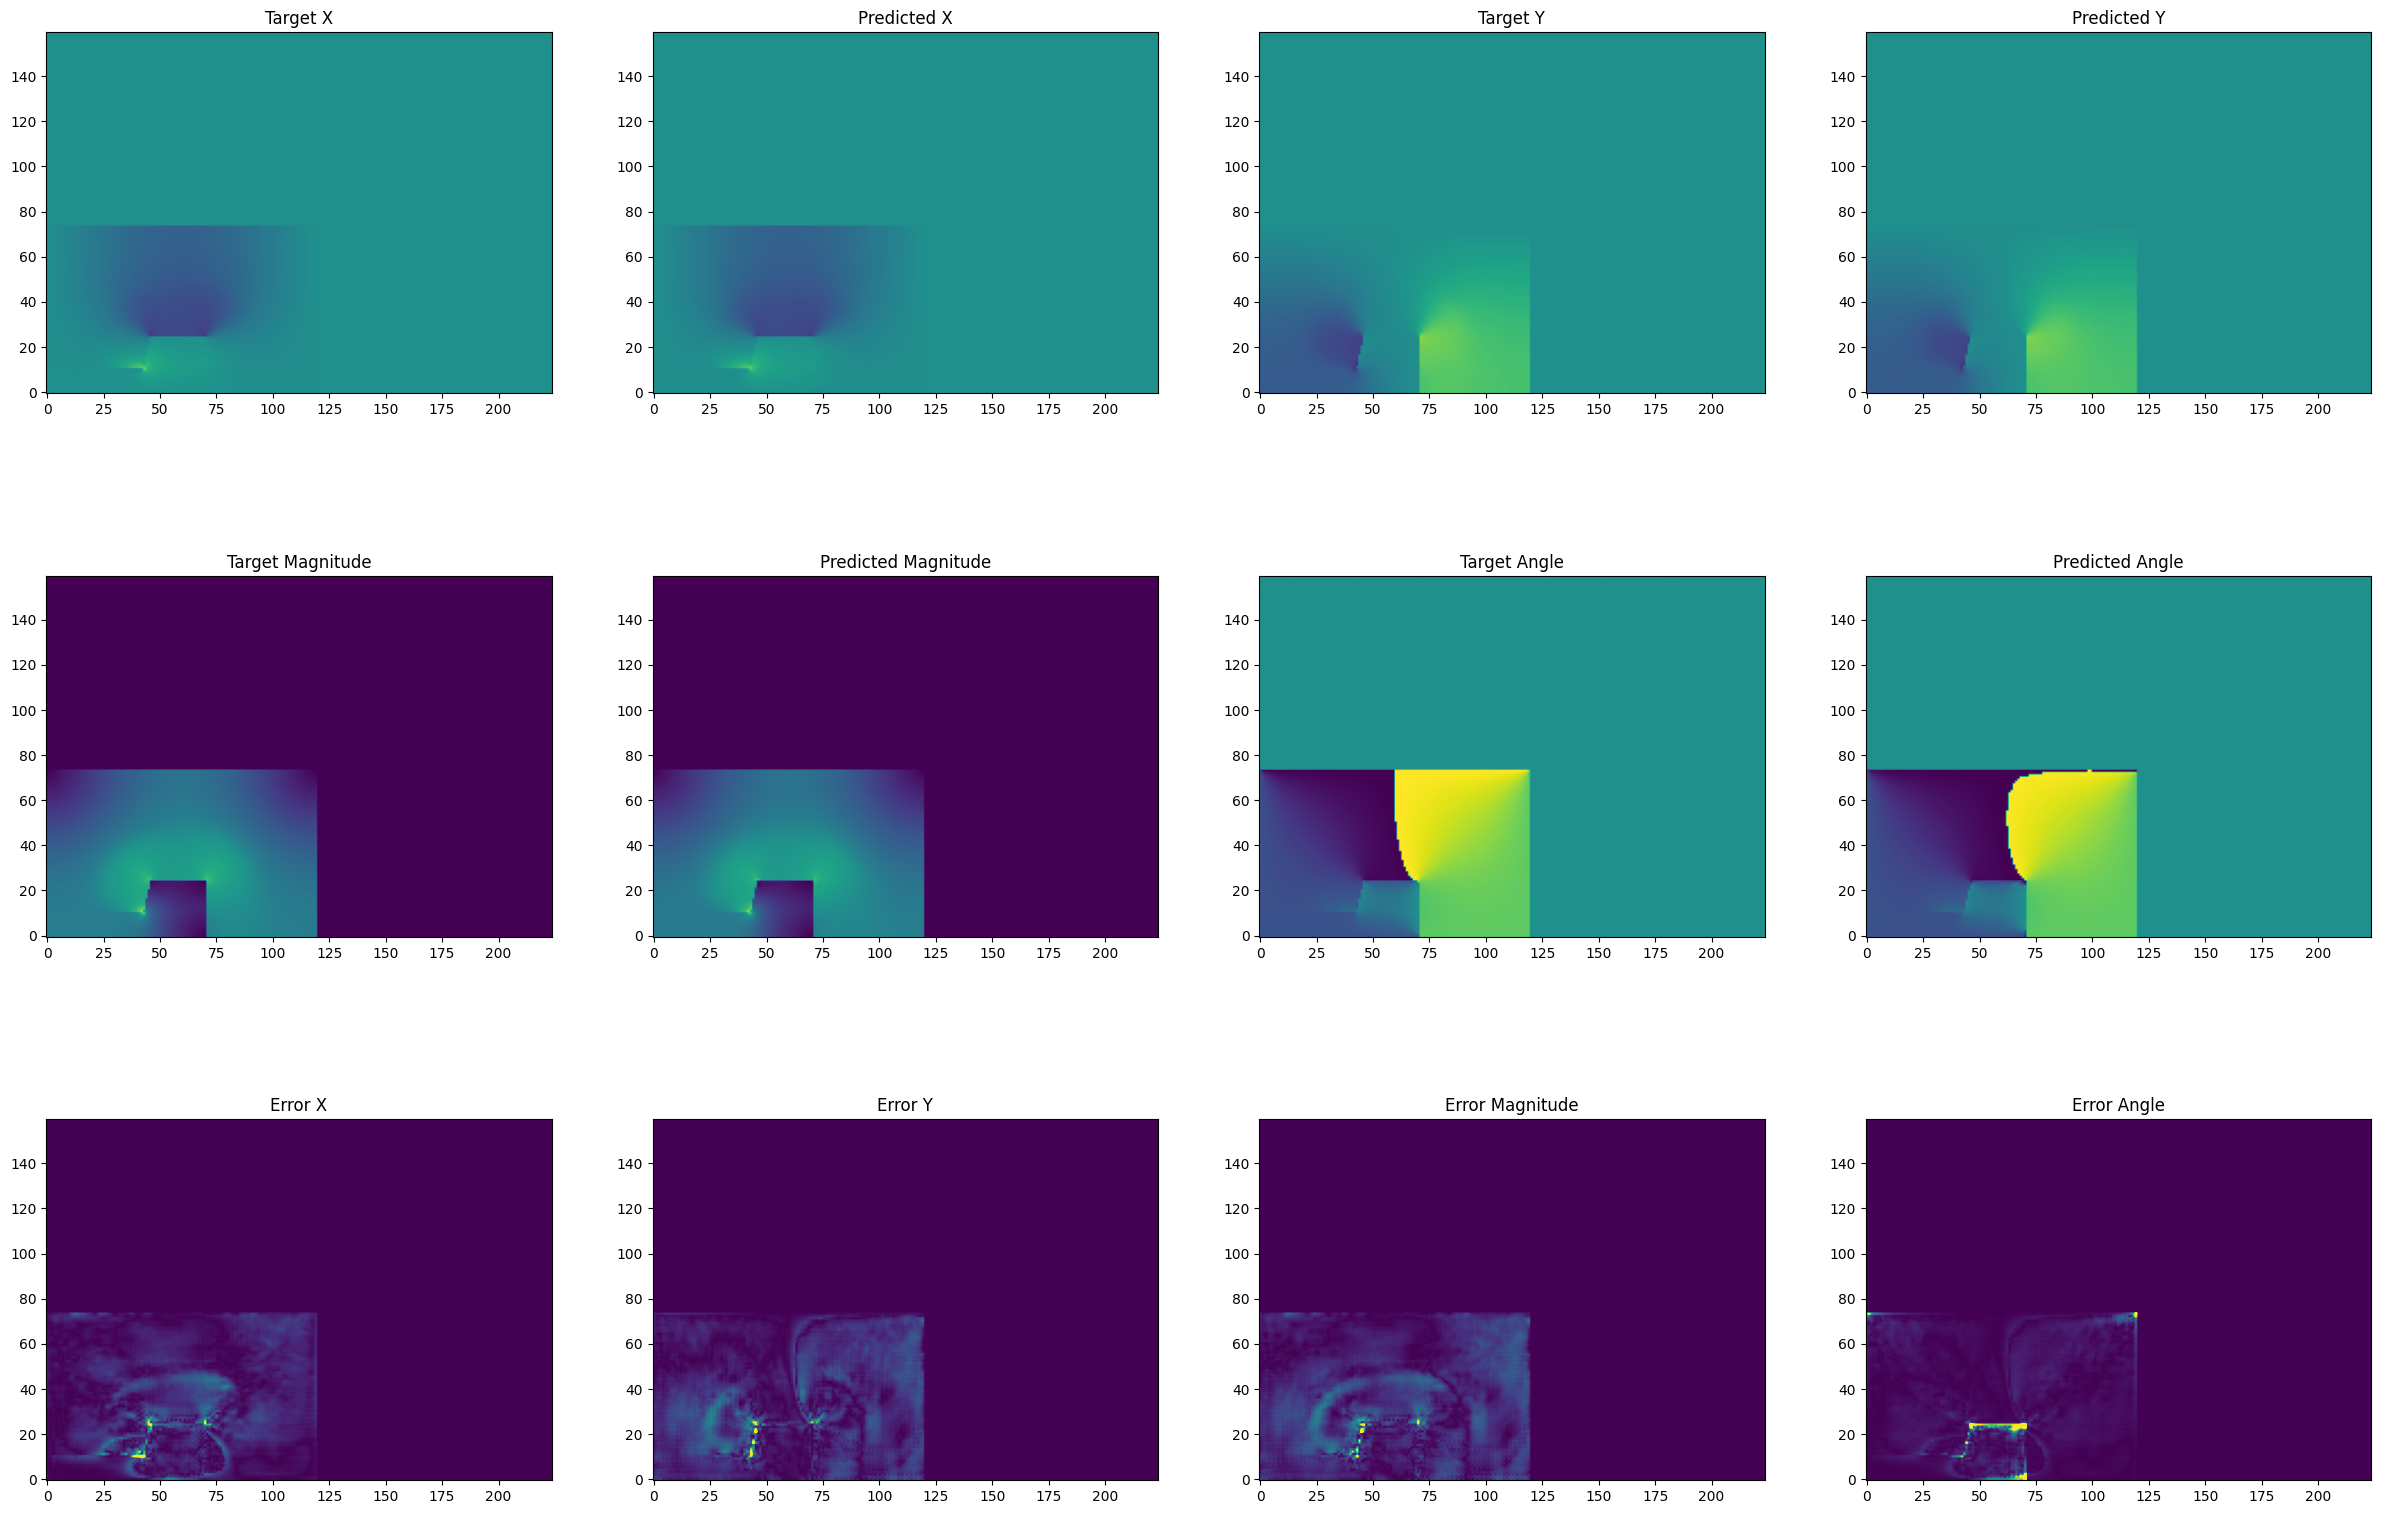

In [5]:
# test model
for i, (x, y) in enumerate(test_loader):
    
    if i == 8:
        sample = 28
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)
        with torch.no_grad():
            y_pred = model(x)
        print(y_pred.shape)
        print(y.shape)
        print(x.shape)
        prio = x[sample, 17, :, :].cpu().detach().numpy().T
        tar_x = y[sample, 0, :, :].cpu().detach().numpy().T
        tar_y = y[sample, 1, :, :].cpu().detach().numpy().T
        pred_x = y_pred[sample, 0, :, :].cpu().detach().numpy().T
        pred_y = y_pred[sample, 1, :, :].cpu().detach().numpy().T
        boolprio = prio > 0

        tar_x = tar_x * boolprio
        tar_y = tar_y * boolprio
        pred_x = pred_x * boolprio
        pred_y = pred_y * boolprio

        # interpret x and y as strength for a vector field in x and y direction - calculate the magnitude and the angle
        tar_mag = np.sqrt(tar_x**2 + tar_y**2)
        tar_ang = np.arctan2(tar_y, tar_x) * boolprio
        pred_mag = np.sqrt(pred_x**2 + pred_y**2)
        pred_ang = np.arctan2(pred_y, pred_x) * boolprio

        # calculate the error
        error_x = np.abs(tar_x - pred_x)
        error_y = np.abs(tar_y - pred_y)
        error_mag = np.abs(tar_mag - pred_mag)
        error_ang = np.abs(np.mod(tar_ang - pred_ang + np.pi, 2*np.pi) - np.pi)

        fig, ax = plt.subplots(3, 4, figsize=(30, 20))
        ax[0, 0].imshow(tar_x, origin='lower', vmin=-2, vmax=2)
        ax[0, 0].set_title("Target X")
        ax[0, 1].imshow(pred_x, origin='lower', vmin=-2, vmax=2)
        ax[0, 1].set_title("Predicted X")
        ax[0, 2].imshow(tar_y, origin='lower', vmin=-2, vmax=2)
        ax[0, 2].set_title("Target Y")
        ax[0, 3].imshow(pred_y, origin='lower', vmin=-2, vmax=2)
        ax[0, 3].set_title("Predicted Y")
        ax[1, 0].imshow(tar_mag, origin='lower', vmin=0, vmax=2)
        ax[1, 0].set_title("Target Magnitude")
        ax[1, 1].imshow(pred_mag, origin='lower', vmin=0, vmax=2)
        ax[1, 1].set_title("Predicted Magnitude")
        ax[1, 2].imshow(tar_ang, origin='lower', vmin=-np.pi, vmax=np.pi)
        ax[1, 2].set_title("Target Angle")
        ax[1, 3].imshow(pred_ang, origin='lower', vmin=-np.pi, vmax=np.pi)
        ax[1, 3].set_title("Predicted Angle")
        ax[2, 0].imshow(error_x, origin='lower', vmin=0, vmax=0.1)
        ax[2, 0].set_title("Error X")
        ax[2, 1].imshow(error_y, origin='lower', vmin=0, vmax=0.1)
        ax[2, 1].set_title("Error Y")
        ax[2, 2].imshow(error_mag, origin='lower', vmin=0, vmax=0.1)
        ax[2, 2].set_title("Error Magnitude")
        ax[2, 3].imshow(error_ang, origin='lower', vmin=0, vmax=0.1*np.pi)
        ax[2, 3].set_title("Error Angle")
        plt.show()
        break

In [83]:
def get_metrics(arr):
    if type(arr) == int:
        arr = np.array([arr])
    # Flatten the 2D array to 1D
    flattened_array = arr.flatten()
    # Filter out the zero values
    
    if len(flattened_array[flattened_array != 0]) > 0:
        non_zero_values = flattened_array[flattened_array != 0]
    else:
        non_zero_values = flattened_array
    # Calculate mean, median, and max
    mean_value = np.mean(non_zero_values)
    median_value = np.median(non_zero_values)
    max_value = np.max(non_zero_values)
    # Calculate the 95th percentile
    perc95 = np.percentile(non_zero_values, 95)
    return mean_value, median_value, max_value, perc95, 1

def get_errors(model, test_loader, figureOfMerit="all", metric="mean", norm=None):
    # create a histogram that shows the mean error for each sample
    error_x = []
    error_y = []
    error_mag = []
    error_ang = []
    for i, (x, y) in enumerate(test_loader):
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)
        
        for sample in range(x.shape[0]):
            if figureOfMerit == "all":
                mask = x[sample, 17, :, :] > 0
            elif figureOfMerit == "aperture":
                mask = x[sample, 16, :, :] > 0
            elif figureOfMerit == "yoke":
                mask = x[sample, 0, :, :] > 0
            elif figureOfMerit == "coil":
                mask = x[sample, 3, :, :] > 0
            elif figureOfMerit == "rest":
                mask = (x[sample, 17, :, :] > 0) * (x[sample, 16, :, :] == 0) * (x[sample, 0, :, :] == 0) * (x[sample, 3, :, :] == 0)
            else:
                raise ValueError("Unknown figure of merit")
            mask = mask.cpu().detach().numpy().T

            with torch.no_grad():
                y_pred = model(x)
            tar_x = y[sample, 0, :, :].cpu().detach().numpy().T
            tar_y = y[sample, 1, :, :].cpu().detach().numpy().T
            pred_x = y_pred[sample, 0, :, :].cpu().detach().numpy().T
            pred_y = y_pred[sample, 1, :, :].cpu().detach().numpy().T
                
            tar_mag = np.sqrt(tar_x**2 + tar_y**2)
            tar_ang = np.arctan2(tar_y, tar_x)
            pred_mag = np.sqrt(pred_x**2 + pred_y**2)
            pred_ang = np.arctan2(pred_y, pred_x)

            tar_x = tar_x * mask
            tar_y = tar_y * mask
            pred_x = pred_x * mask
            pred_y = pred_y * mask
            tar_mag = tar_mag * mask
            tar_ang = tar_ang * mask
            pred_mag = pred_mag * mask
            pred_ang = pred_ang * mask
            
            # calculate the error
            err_x = np.abs(tar_x - pred_x)
            err_y = np.abs(tar_y - pred_y)
            err_mag = np.abs(tar_mag - pred_mag)
            err_ang = np.abs(np.mod(tar_ang - pred_ang + np.pi, 2*np.pi) - np.pi)

            if norm == "all":
                err_x = np.abs(np.divide(err_x, tar_x))
                err_y = np.abs(np.divide(err_y, tar_y))
                err_mag = np.abs(np.divide(err_mag, tar_mag))
                err_ang = np.abs(np.divide(err_ang, tar_ang))
            elif norm == "max":
                err_x = err_x / np.max(np.abs(tar_x))
                err_y = err_y / np.max(np.abs(tar_y))
                err_mag = err_mag / np.max(np.abs(tar_mag))
                err_ang = err_ang / np.max(np.abs(tar_ang))
            elif norm == "zero":
                err_x = err_x / np.abs(tar_x[0,0]) if tar_x[0,0] != 0 else 0
                err_y = err_y / np.abs(tar_y[0,0]) if tar_y[0,0] != 0 else 0
                err_mag = err_mag / np.abs(tar_mag[0,0]) if tar_mag[0,0] != 0 else 0
                err_ang = err_ang / np.abs(tar_ang[0,0]) if tar_ang[0,0] != 0 else 0
            elif norm == "zeroonly":
                err_x = np.array([err_x[0,0] / tar_x[0,0]])
                err_y = np.array([err_y[0,0] / tar_y[0,0]])
                err_mag = np.array([err_mag[0,0] / tar_mag[0,0]])
                err_ang = np.array([err_ang[0,0] / tar_ang[0,0]])
            else:
                pass

            # # plot mask
            # img = plt.imshow(err_x, origin='lower', vmin=0, vmax=0.1)
            # plt.colorbar(img)
            # plt.show()
            
            # get metrics
            mean_x, median_x, max_x, perc95_x, bvc_x = get_metrics(err_x)
            mean_y, median_y, max_y, perc95_y, bvc_y = get_metrics(err_y)
            mean_mag, median_mag, max_mag, perc95_mag, bvc_mag = get_metrics(err_mag)
            mean_ang, median_ang, max_ang,perc95_ang, bvc_ang = get_metrics(err_ang)

            if metric=="mean":
                error_x.append(mean_x)
                error_y.append(mean_y)
                error_mag.append(mean_mag)
                error_ang.append(mean_ang)
            elif metric=="median":
                error_x.append(median_x)
                error_y.append(median_y)
                error_mag.append(median_mag)
                error_ang.append(median_ang)
            elif metric=="max":
                error_x.append(max_x)
                error_y.append(max_y)
                error_mag.append(max_mag)
                error_ang.append(max_ang)
            elif metric=="perc95":
                error_x.append(perc95_x)
                error_y.append(perc95_y)
                error_mag.append(perc95_mag)
                error_ang.append(perc95_ang)
            elif metric=="bvc":
                error_x.append(bvc_x)
                error_y.append(bvc_y)
                error_mag.append(bvc_mag)
                error_ang.append(bvc_ang)
            else:
                raise ValueError("Unknown metric")
            

    error_x = np.array(error_x)
    error_y = np.array(error_y)
    error_mag = np.array(error_mag)
    error_ang = np.array(error_ang)
    return error_x, error_y, error_mag, error_ang

In [63]:
def plot_histogram(ax, data, title, bins, range):
    ax.set_xlim(range)
    counts, bin_edges = np.histogram(data, bins=bins, range=range)
    ax.set_title(title)
    ax.set_xlabel("Mean Error")
    ax.set_ylabel("Frequency")
    ax.set_yscale("log")
    bin_centres = (bin_edges[:-1] + bin_edges[1:]) * 0.5
    err = np.sqrt(counts)
    ax.errorbar(bin_centres, counts, yerr=err, fmt='o')

def plot_histograms(error_x, error_y, error_mag, error_ang):
    fig, ax = plt.subplots(2, 2, figsize=(30, 10))
    plot_histogram(ax[0, 0], error_x, "Error X", 50, (0, 0.5))
    plot_histogram(ax[0, 1], error_y, "Error Y", 50, (0, 0.5))
    plot_histogram(ax[1, 0], error_mag, "Error Magnitude", 50, (0, 0.5))
    plot_histogram(ax[1, 1], error_ang, "Error Angle", 180, (0, np.pi))
    plt.show()

def getErrorHistograms(model, test_loader, figureOfMerit="all", metric="mean", norm=None):
    print("-------------------------")
    print(figureOfMerit)
    error_x, error_y, error_mag, error_ang = get_errors(model, test_loader, figureOfMerit, metric, norm)
    plot_histograms(error_x, error_y, error_mag, error_ang)
    print(metric, " error x:", np.mean(error_x))
    print(metric, " error y:", np.mean(error_y))
    print(metric, " error magnitude:", np.mean(error_mag))
    print(metric, " error angle:", np.mean(error_ang))
    print(metric, " error x std:", np.std(error_x))
    print(metric, " error y std:", np.std(error_y))
    print(metric, " error magnitude std:", np.std(error_mag))
    print(metric, " error angle std:", np.std(error_ang))


-------------------------
all


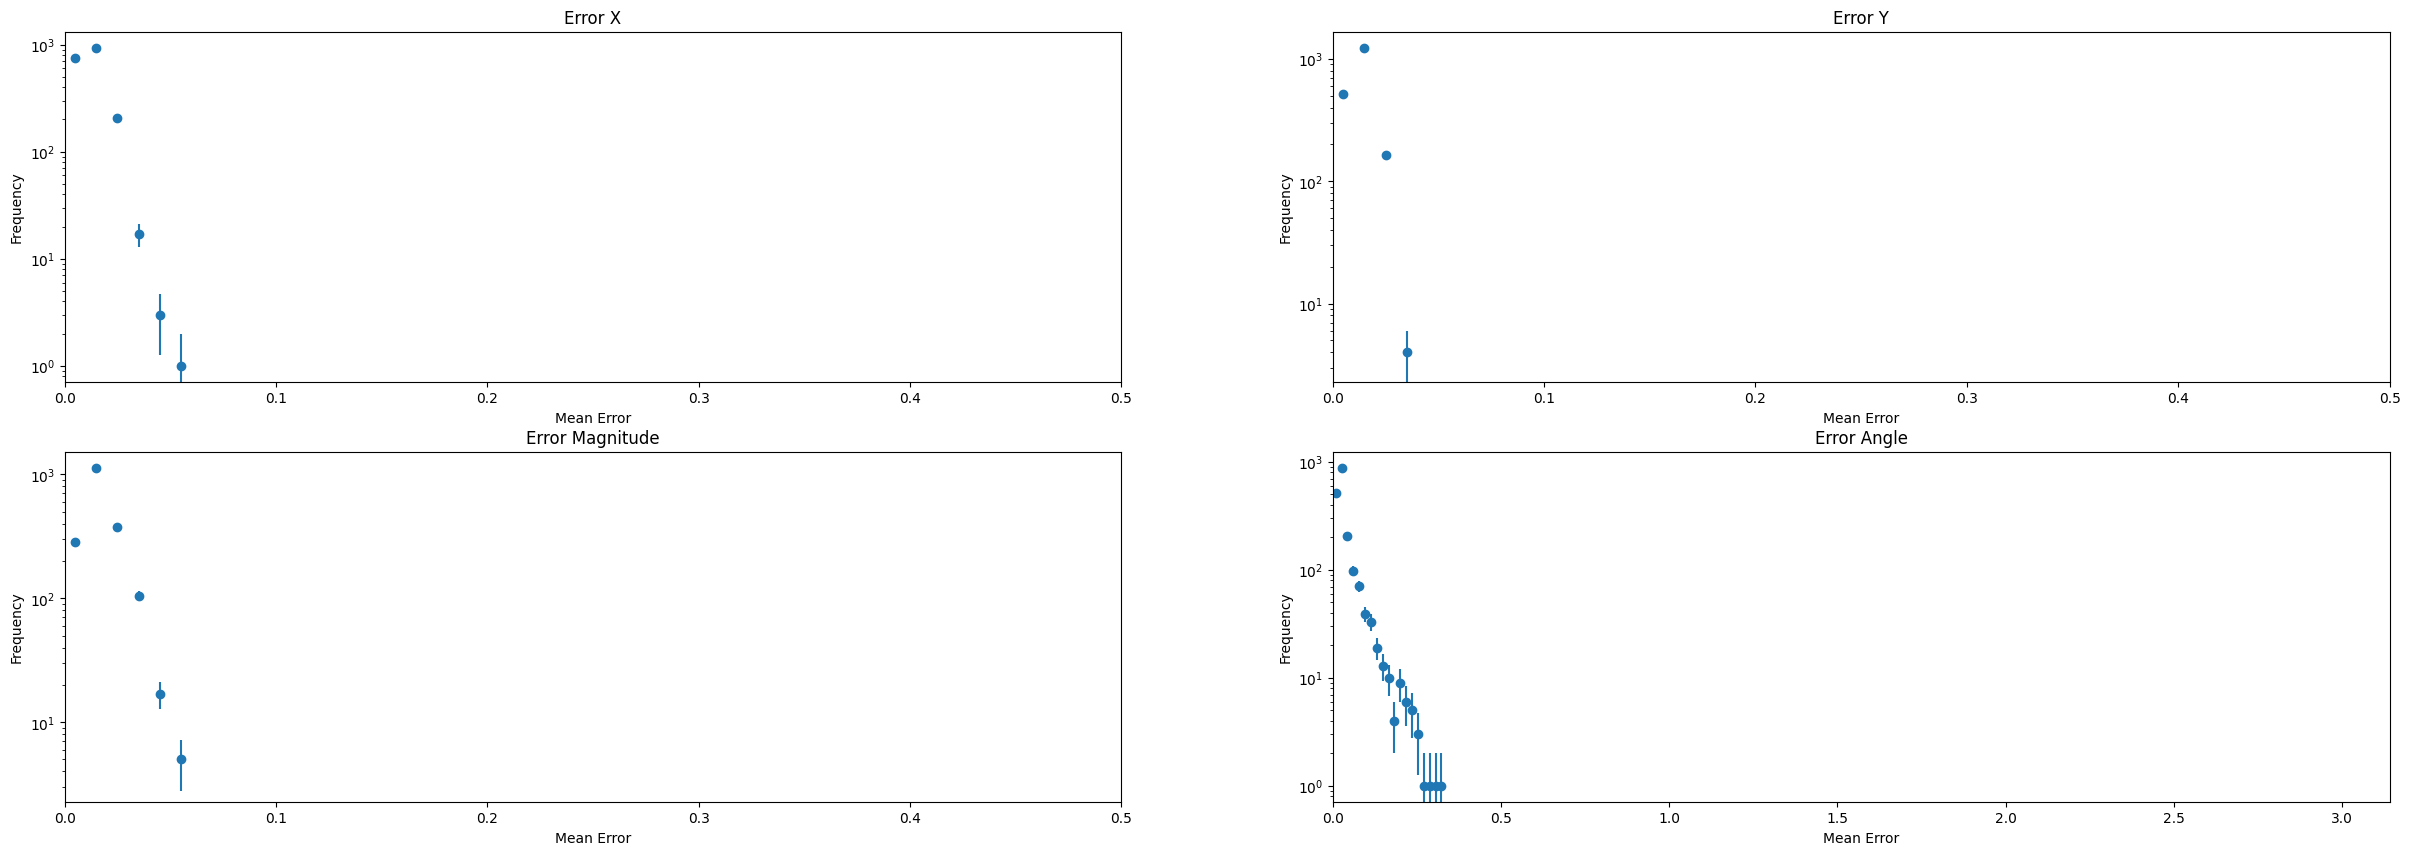

mean  error x: 0.012770861
mean  error y: 0.013277567
mean  error magnitude: 0.017022343
mean  error angle: 0.03617265
mean  error x std: 0.0057498654
mean  error y std: 0.0045297444
mean  error magnitude std: 0.0074405577
mean  error angle std: 0.03647502
-------------------------
aperture


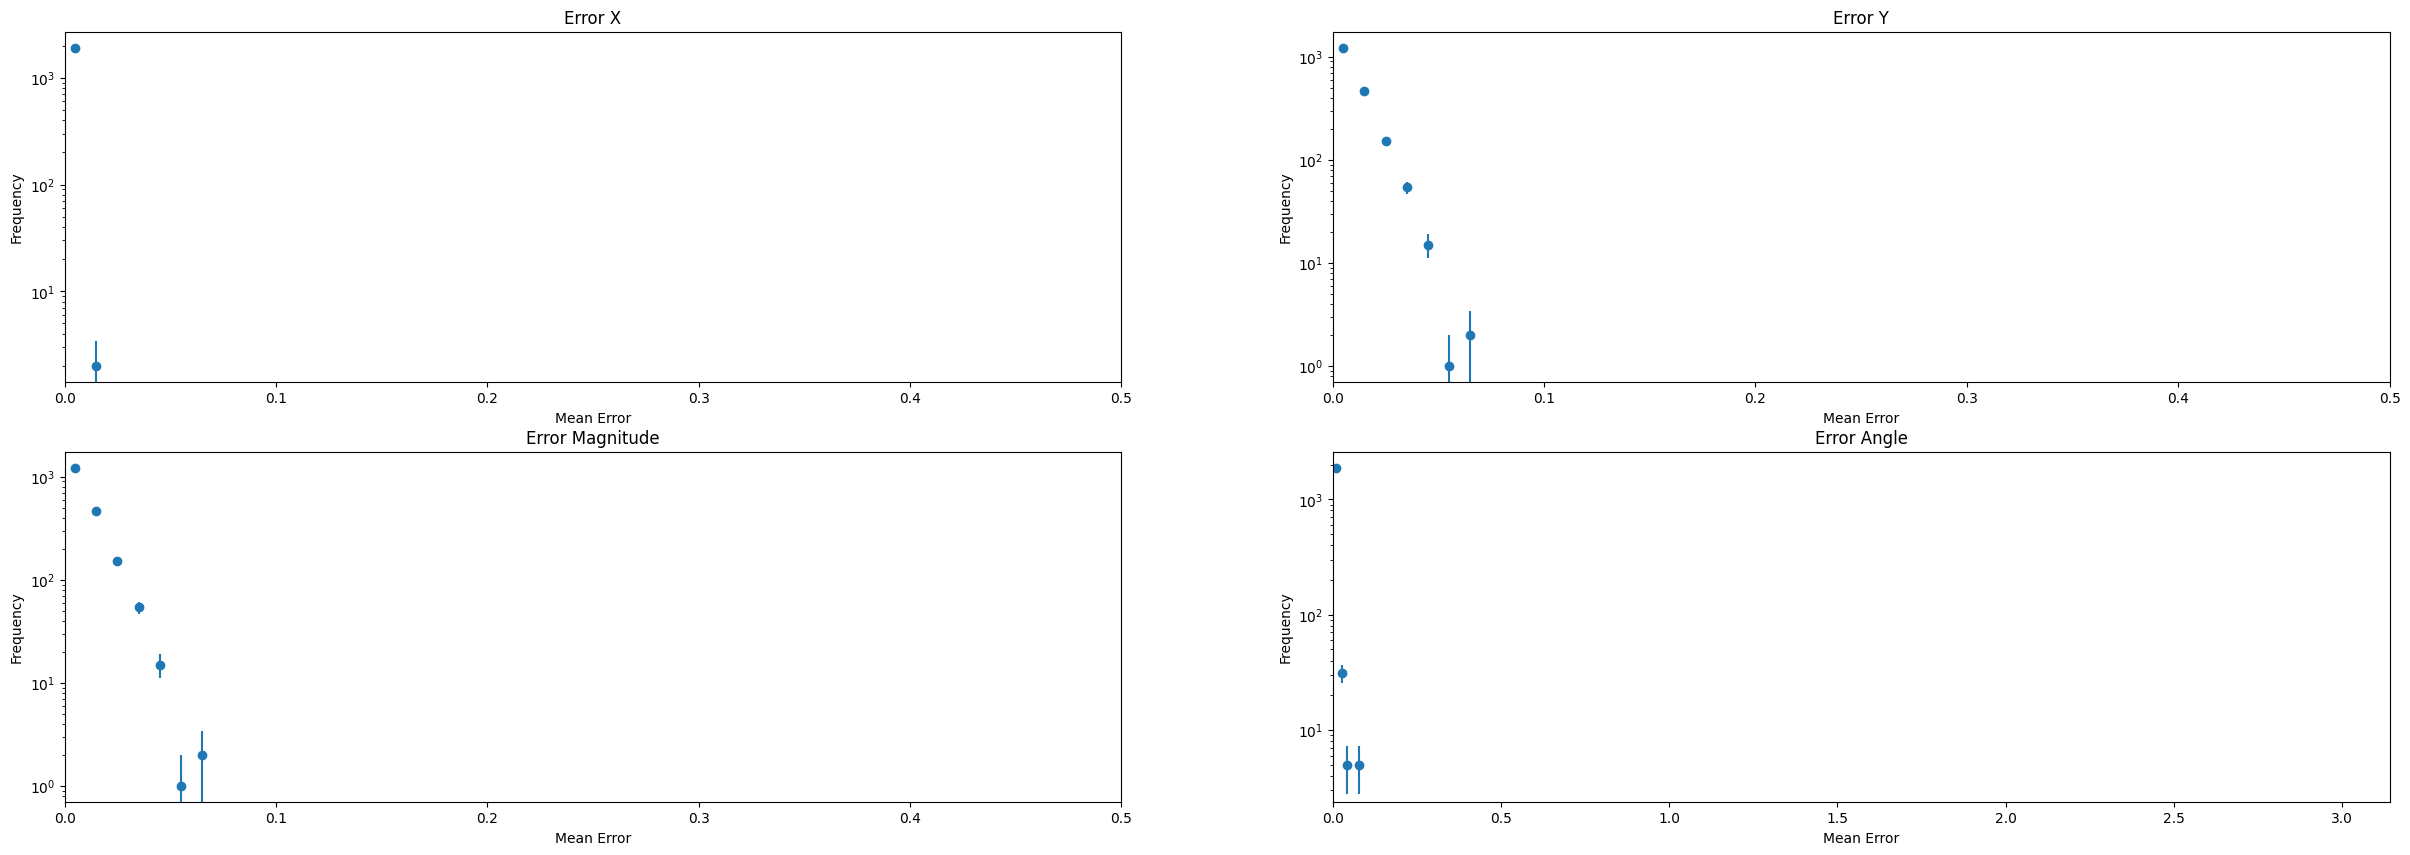

mean  error x: 0.0027492354
mean  error y: 0.010231332
mean  error magnitude: 0.010232383
mean  error angle: 0.0047943415
mean  error x std: 0.0017746285
mean  error y std: 0.008219566
mean  error magnitude std: 0.008219204
mean  error angle std: 0.0057705557
-------------------------
yoke


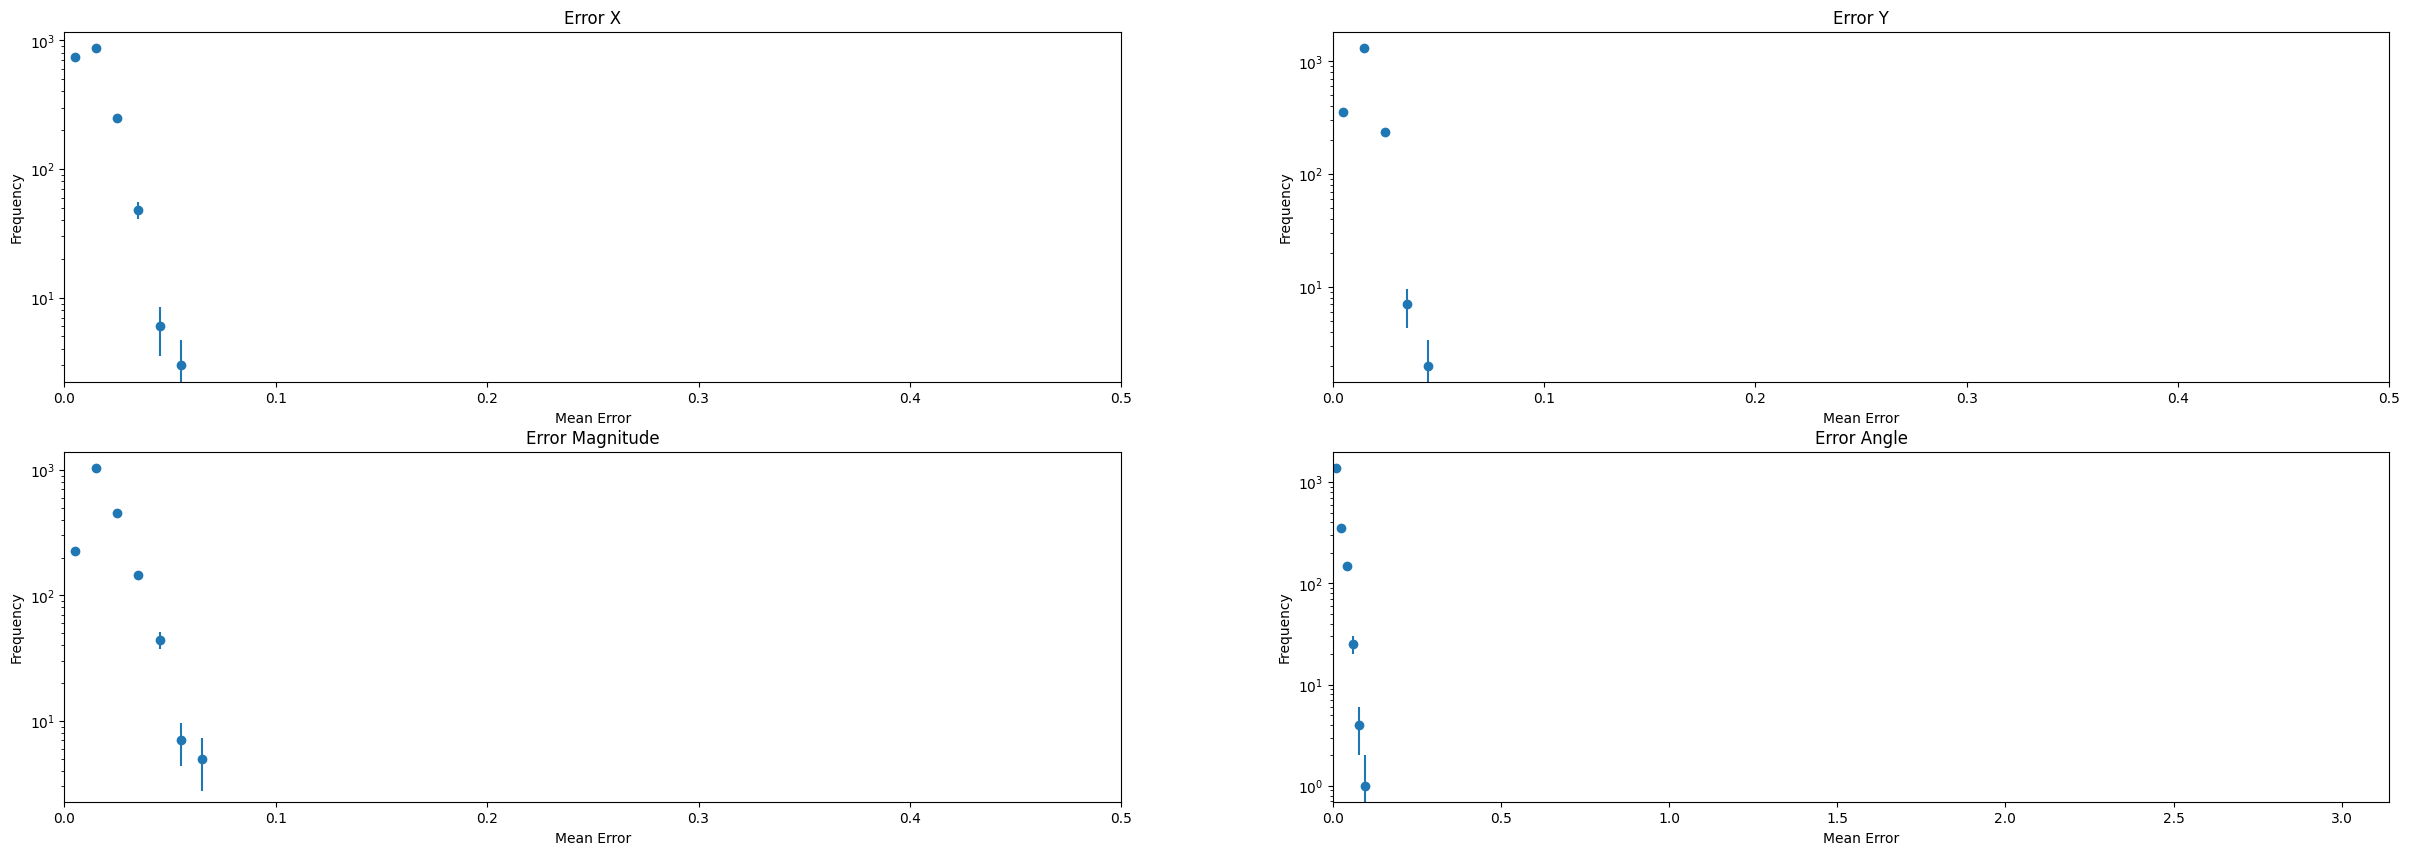

mean  error x: 0.013372469
mean  error y: 0.014403804
mean  error magnitude: 0.018661108
mean  error angle: 0.017018206
mean  error x std: 0.006844255
mean  error y std: 0.0047615496
mean  error magnitude std: 0.0086609945
mean  error angle std: 0.011008053
-------------------------
coil


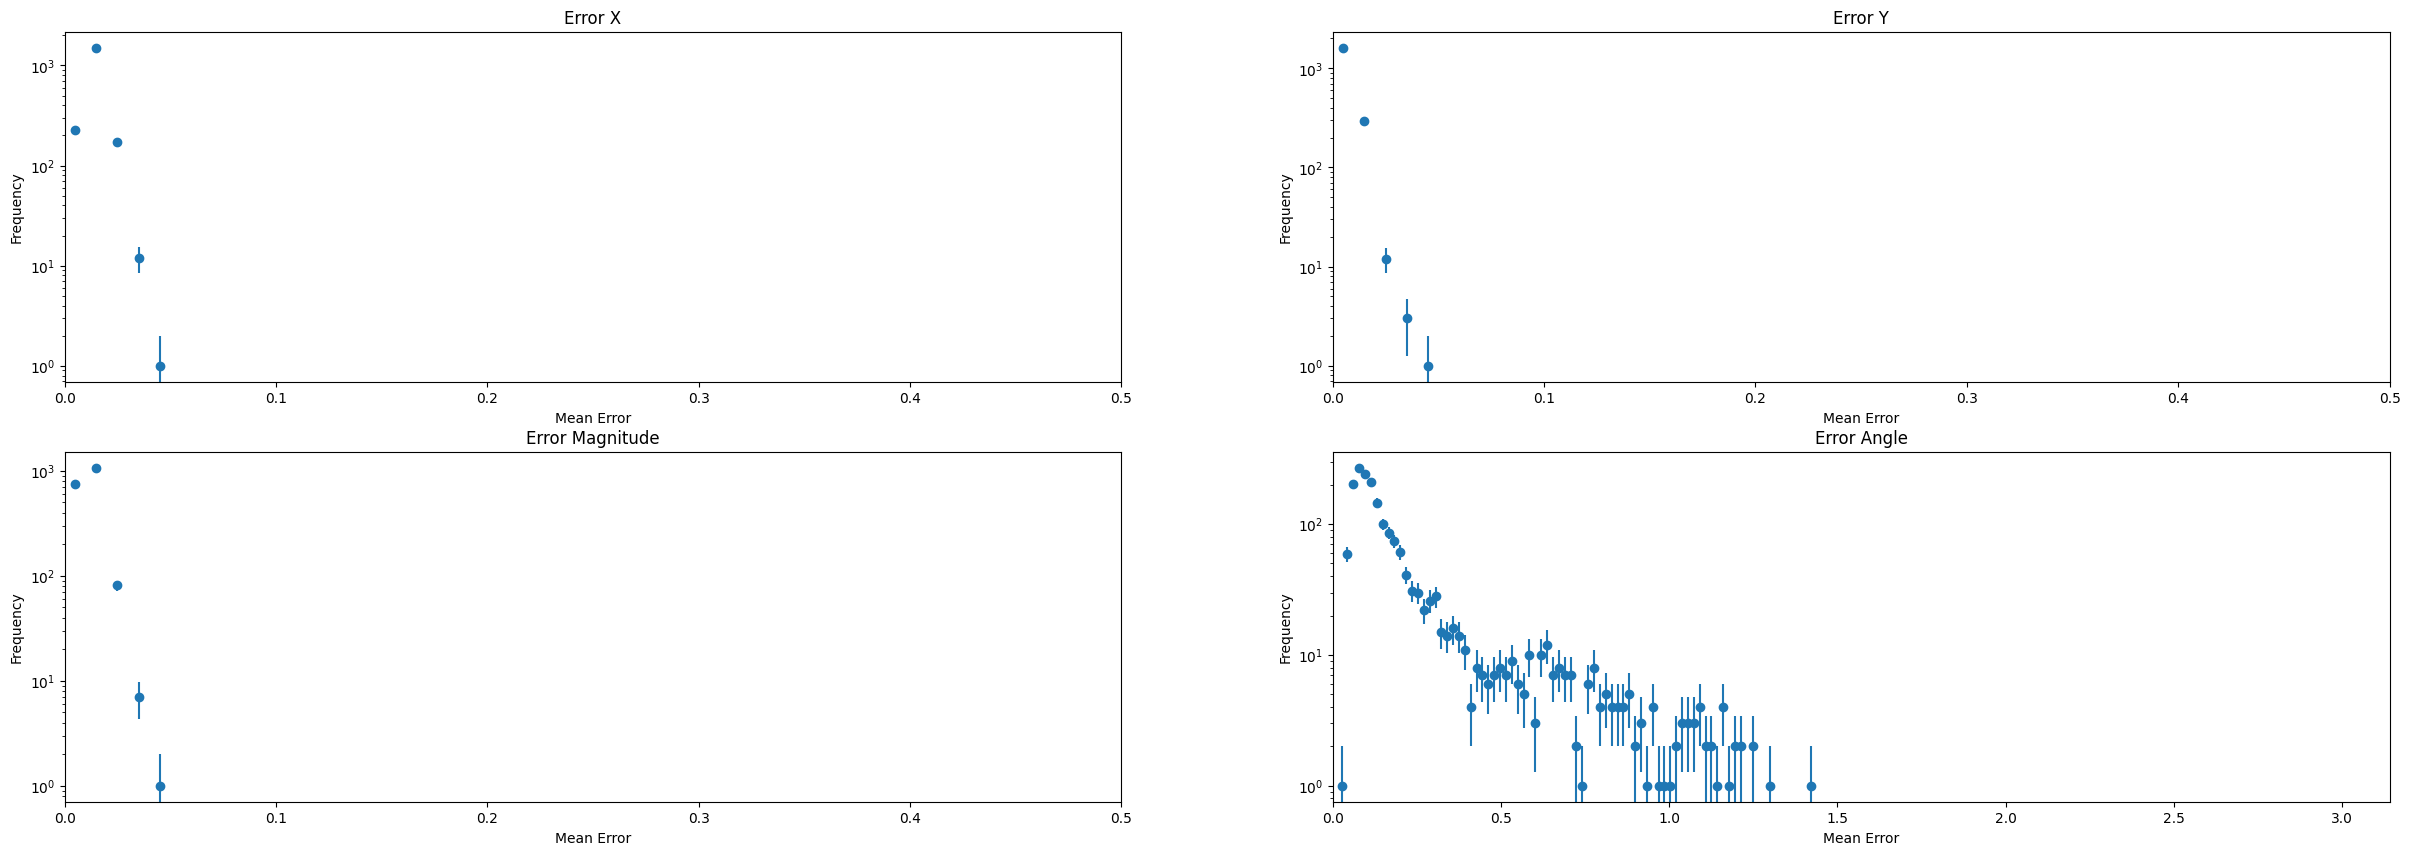

mean  error x: 0.014035059
mean  error y: 0.0073140273
mean  error magnitude: 0.011699425
mean  error angle: 0.20125704
mean  error x std: 0.0043348866
mean  error y std: 0.0035541262
mean  error magnitude std: 0.004244666
mean  error angle std: 0.21380822
-------------------------
rest


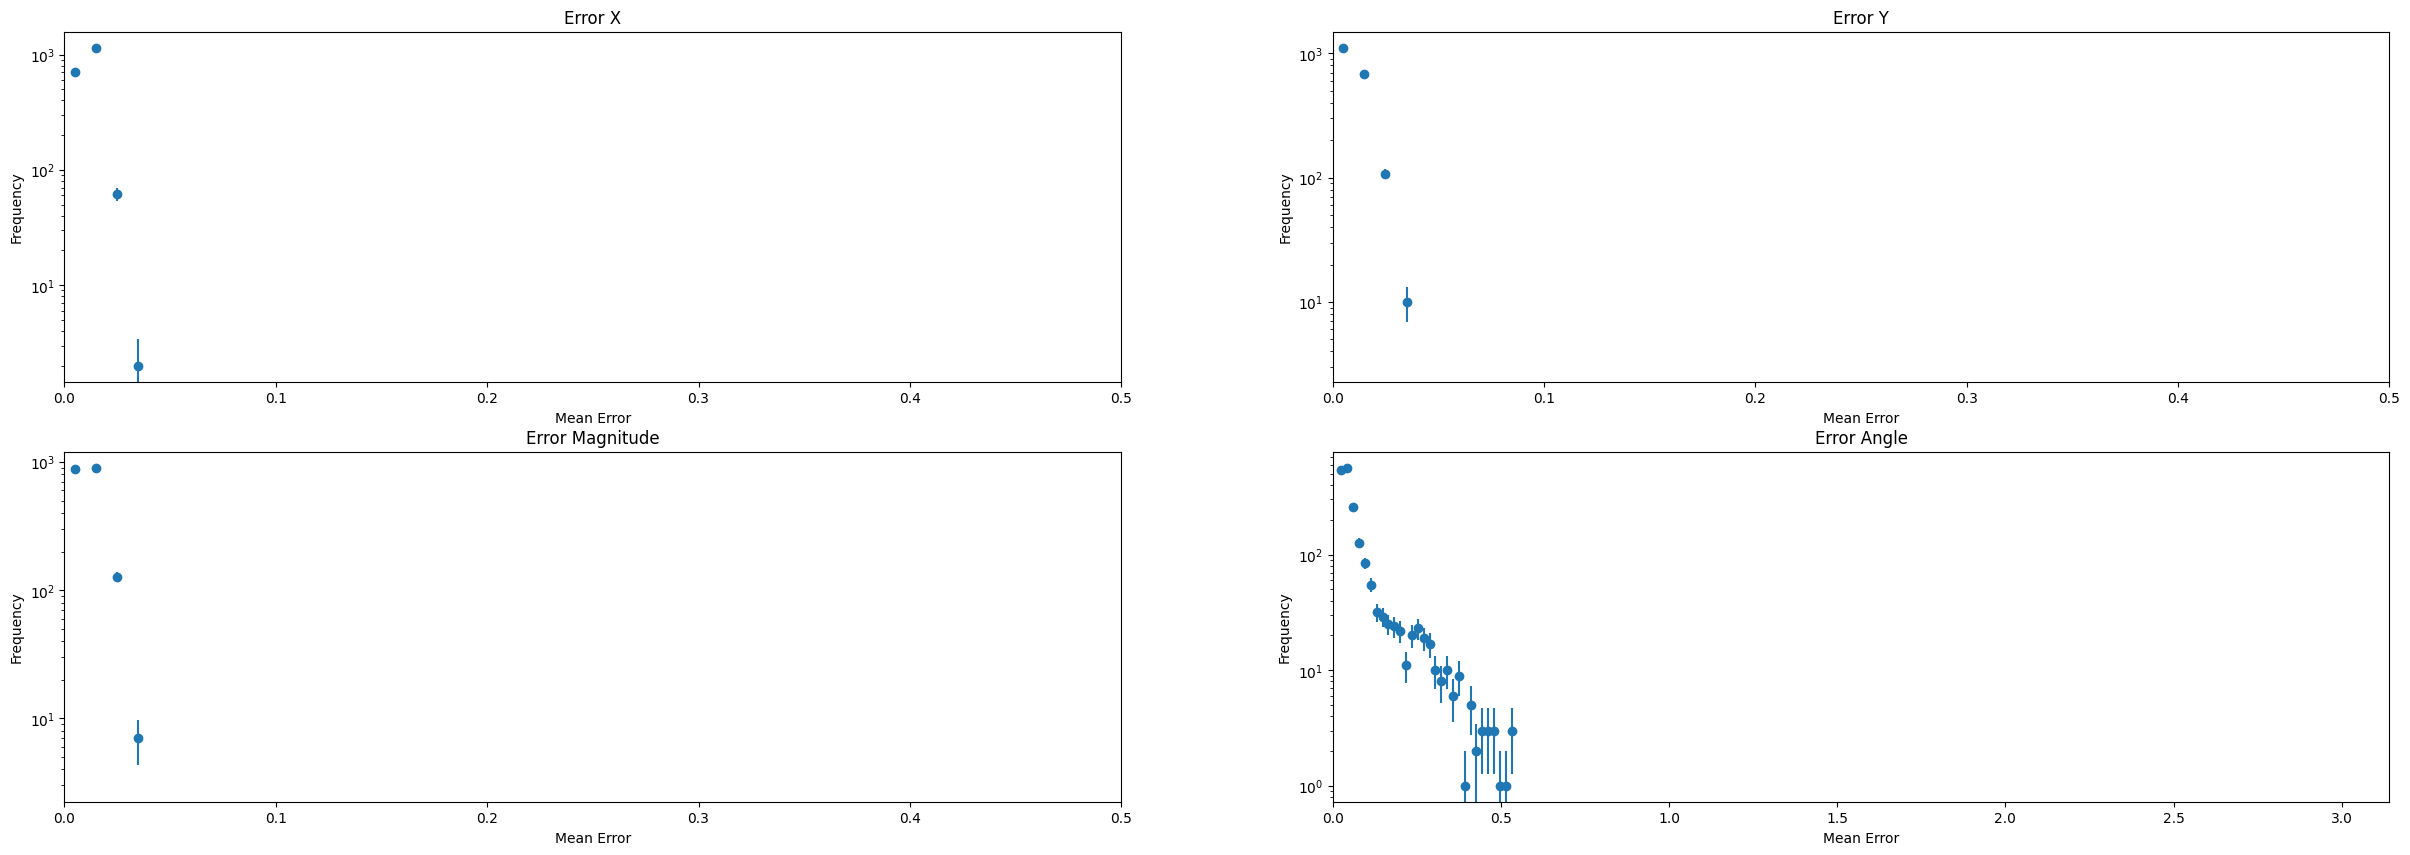

mean  error x: 0.011928637
mean  error y: 0.010346423
mean  error magnitude: 0.011531115
mean  error angle: 0.07717644
mean  error x std: 0.003624838
mean  error y std: 0.0053605326
mean  error magnitude std: 0.004970869
mean  error angle std: 0.07985148


In [48]:
# mean
getErrorHistograms(model, test_loader, figureOfMerit="all")
getErrorHistograms(model, test_loader, figureOfMerit="aperture")
getErrorHistograms(model, test_loader, figureOfMerit="yoke")
getErrorHistograms(model, test_loader, figureOfMerit="coil")
getErrorHistograms(model, test_loader, figureOfMerit="rest")

-------------------------
all


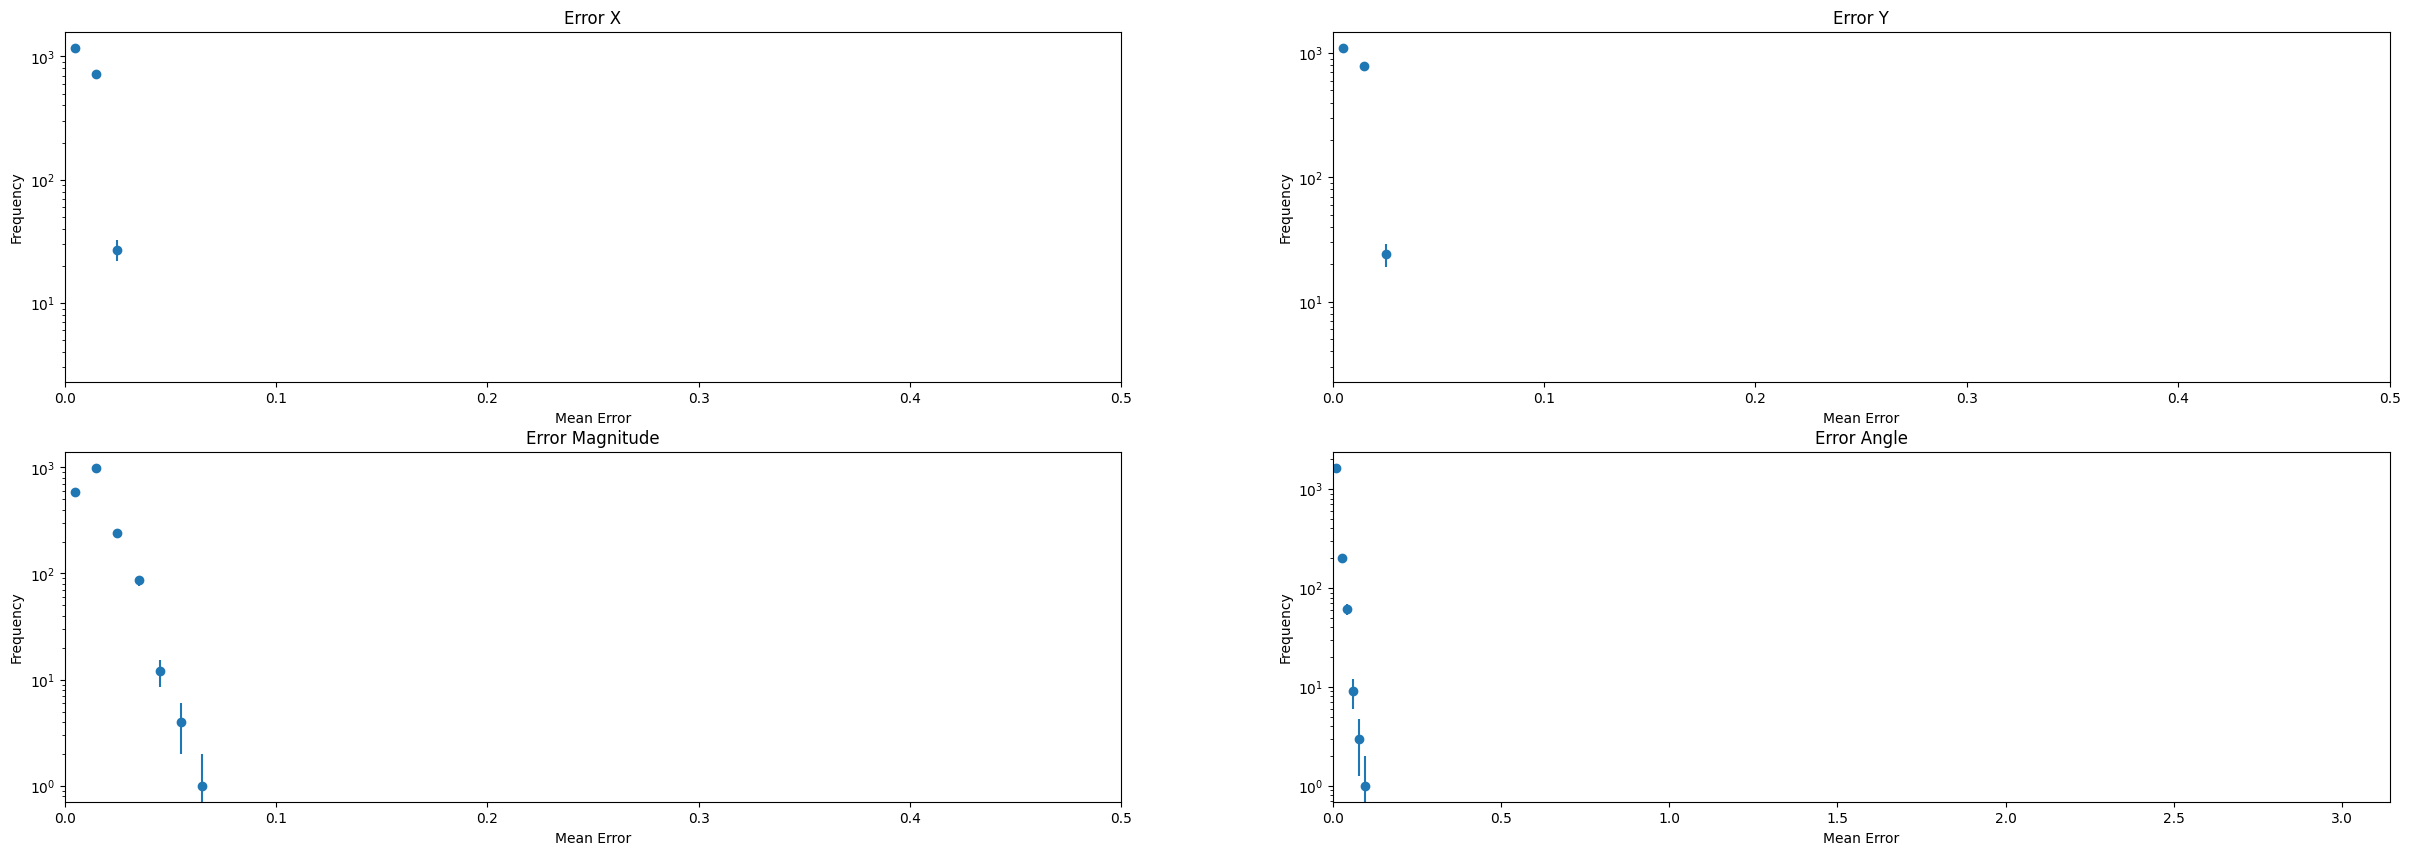

Mean error x: 0.009644931
Mean error y: 0.009752493
Mean error magnitude: 0.014549918
Mean error angle: 0.012750954
Mean error x std: 0.003807143
Mean error y std: 0.0037694743
Mean error magnitude std: 0.0075294273
Mean error angle std: 0.008975635
-------------------------
aperture


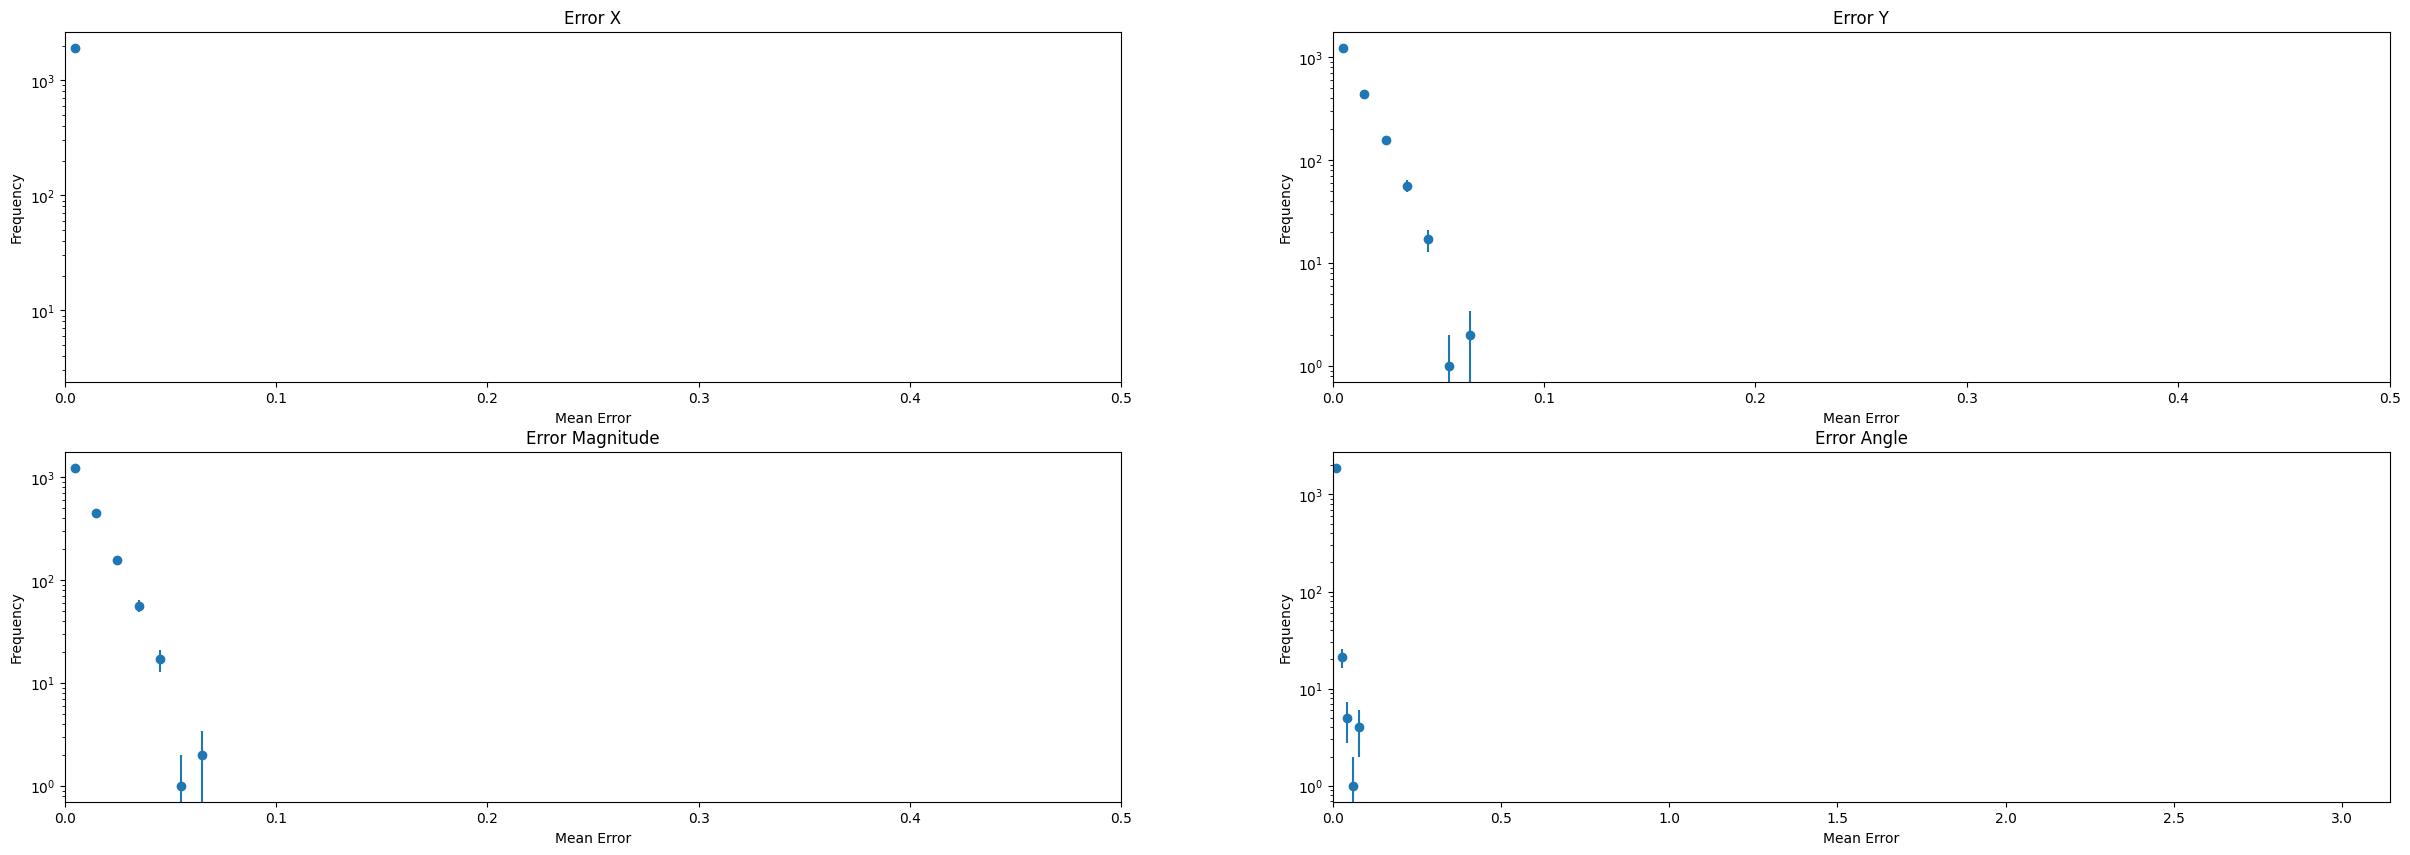

Mean error x: 0.0019074118
Mean error y: 0.009987393
Mean error magnitude: 0.009988839
Mean error angle: 0.0035350178
Mean error x std: 0.0013411008
Mean error y std: 0.008466456
Mean error magnitude std: 0.008466271
Mean error angle std: 0.005318978
-------------------------
yoke


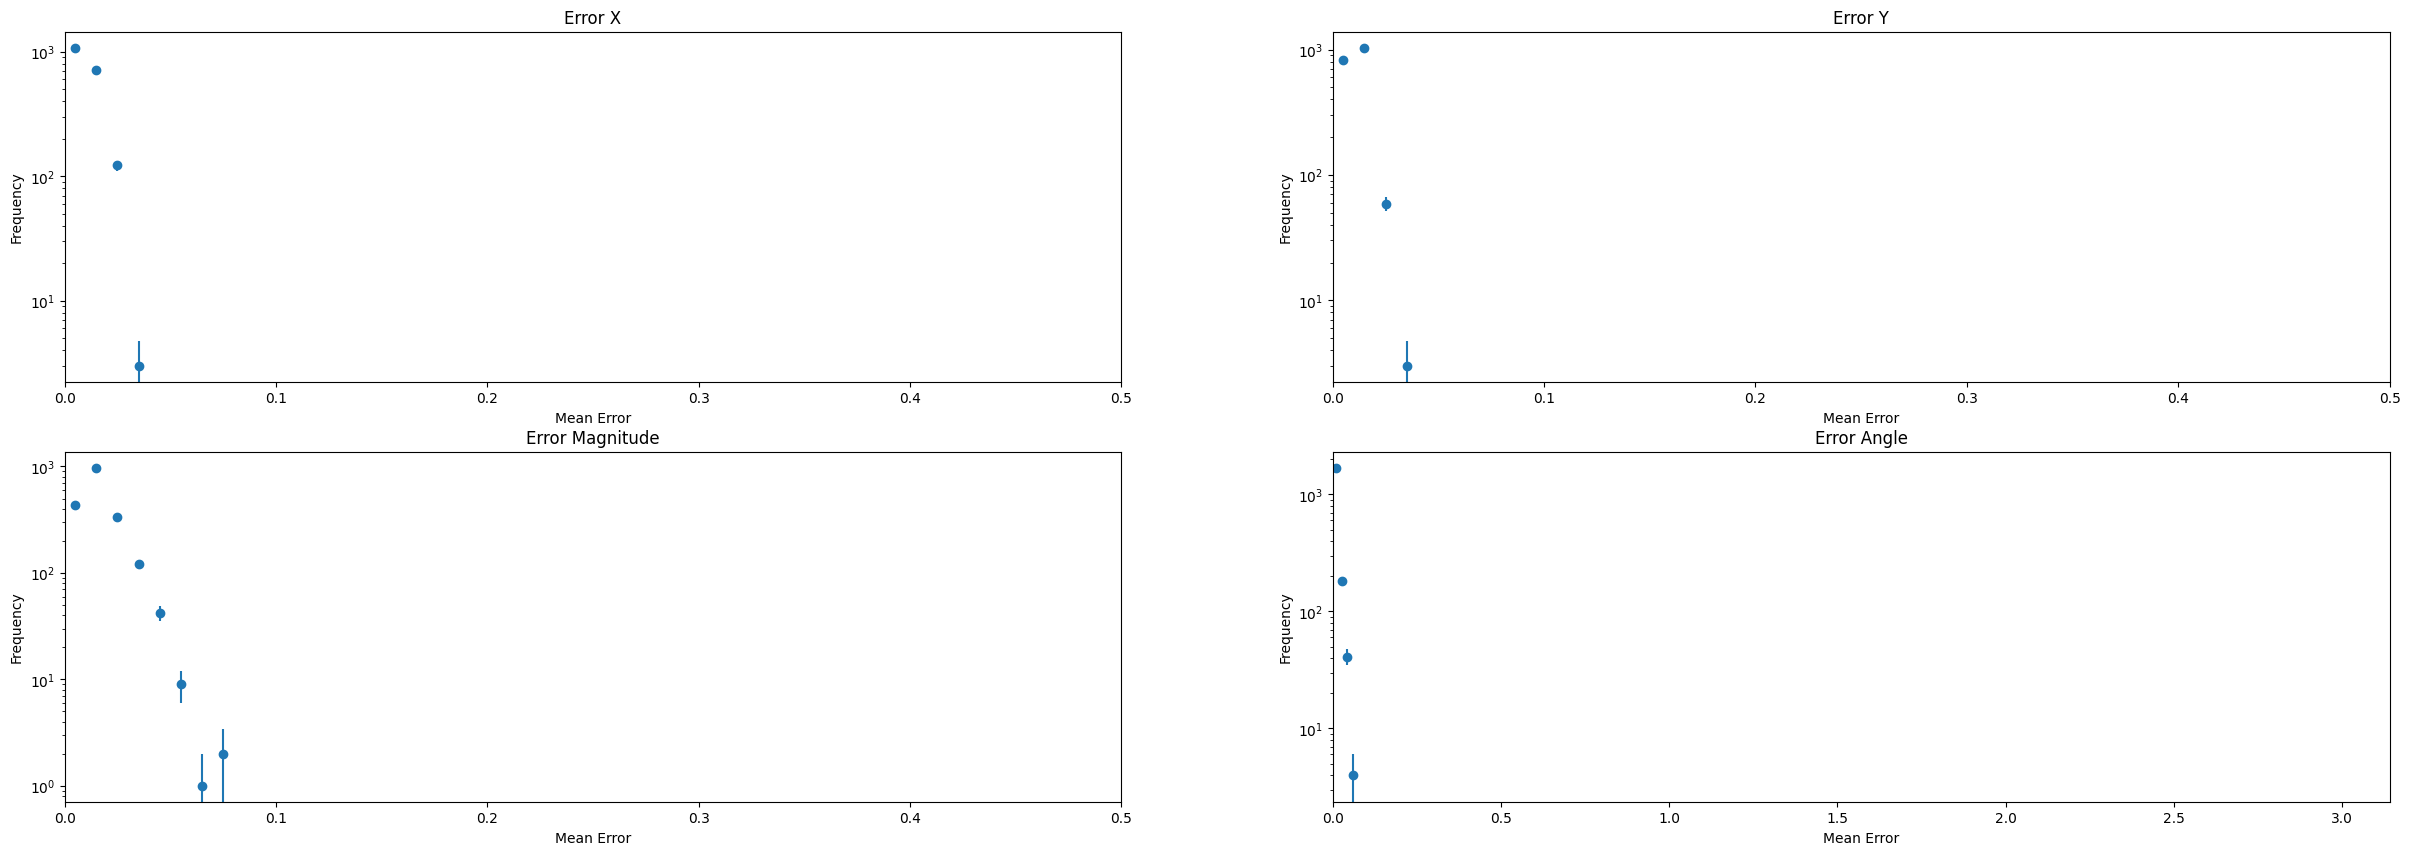

Mean error x: 0.0105824275
Mean error y: 0.0112166405
Mean error magnitude: 0.01681515
Mean error angle: 0.01139743
Mean error x std: 0.00513512
Mean error y std: 0.0041696588
Mean error magnitude std: 0.009135414
Mean error angle std: 0.0076472145
-------------------------
coil


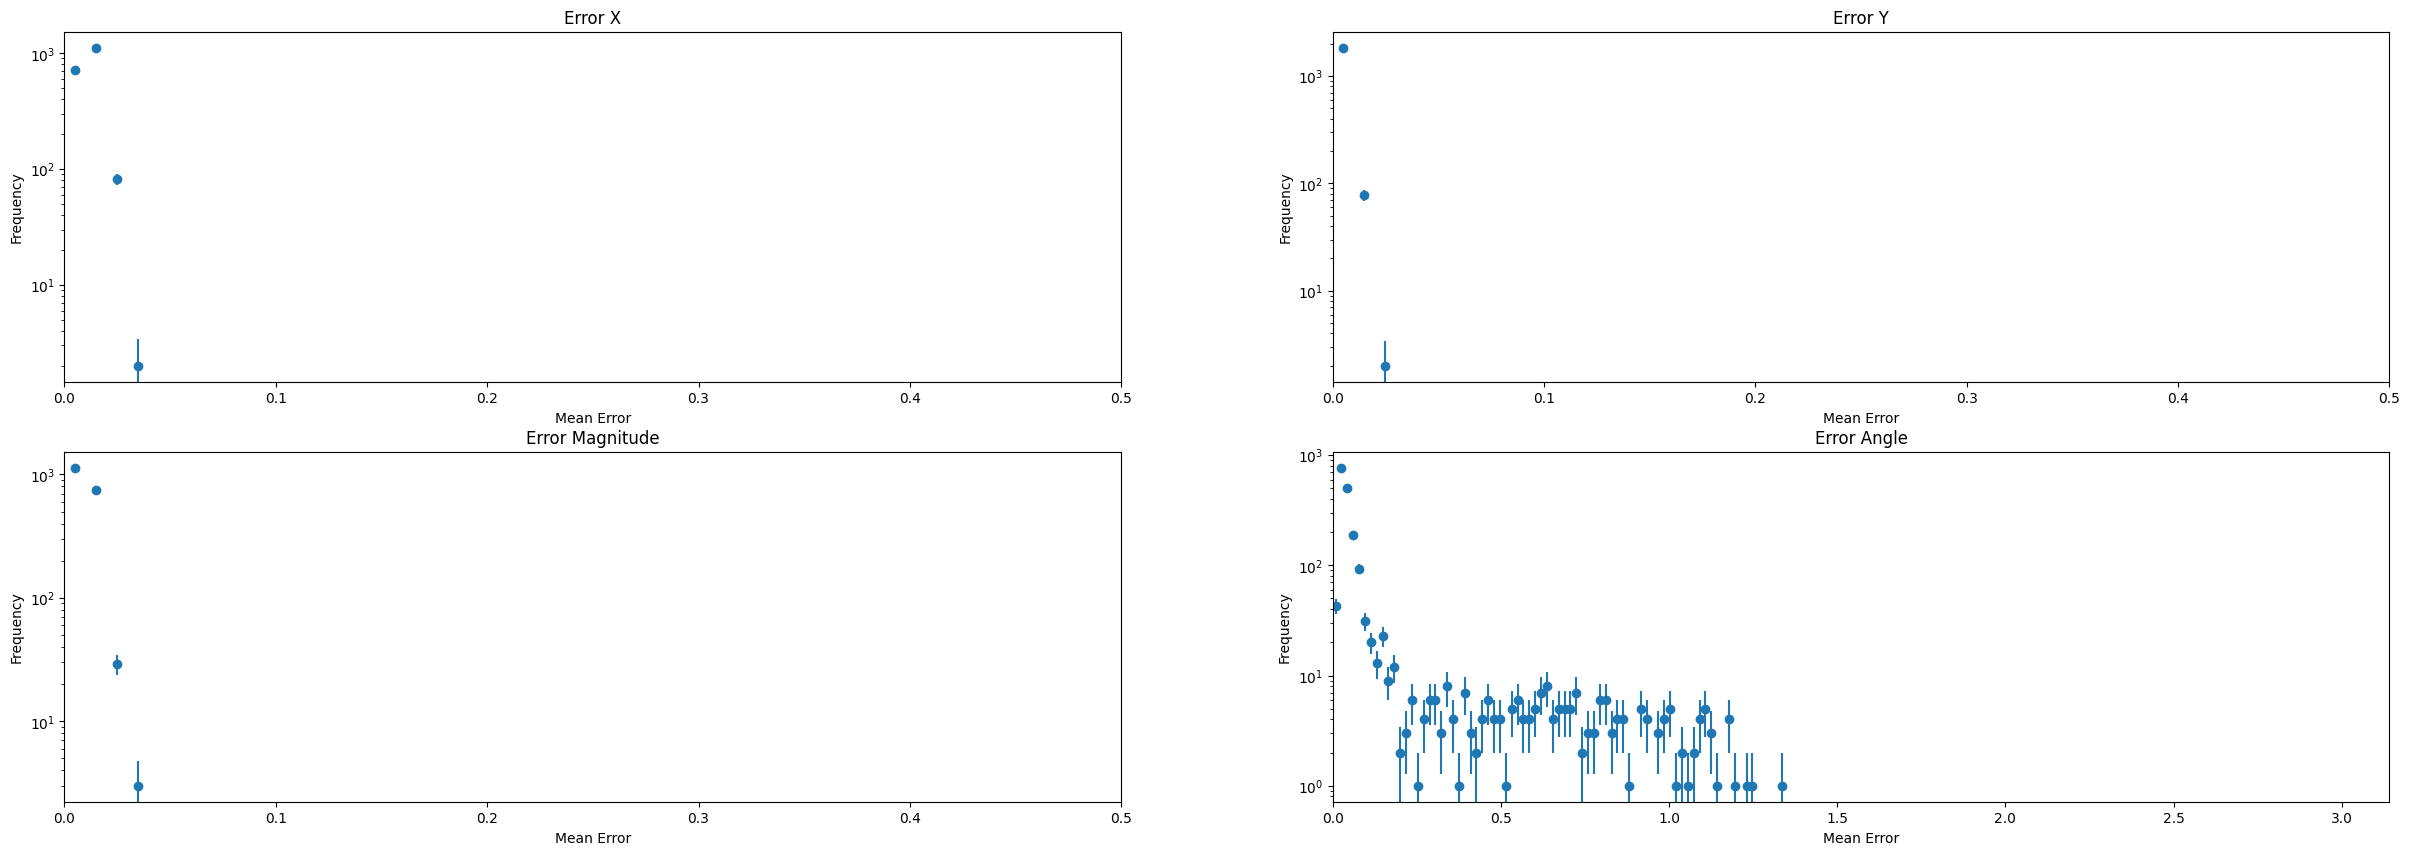

Mean error x: 0.011742012
Mean error y: 0.005106071
Mean error magnitude: 0.009689971
Mean error angle: 0.11394712
Mean error x std: 0.003942644
Mean error y std: 0.002394742
Mean error magnitude std: 0.0038390348
Mean error angle std: 0.21766907
-------------------------
rest


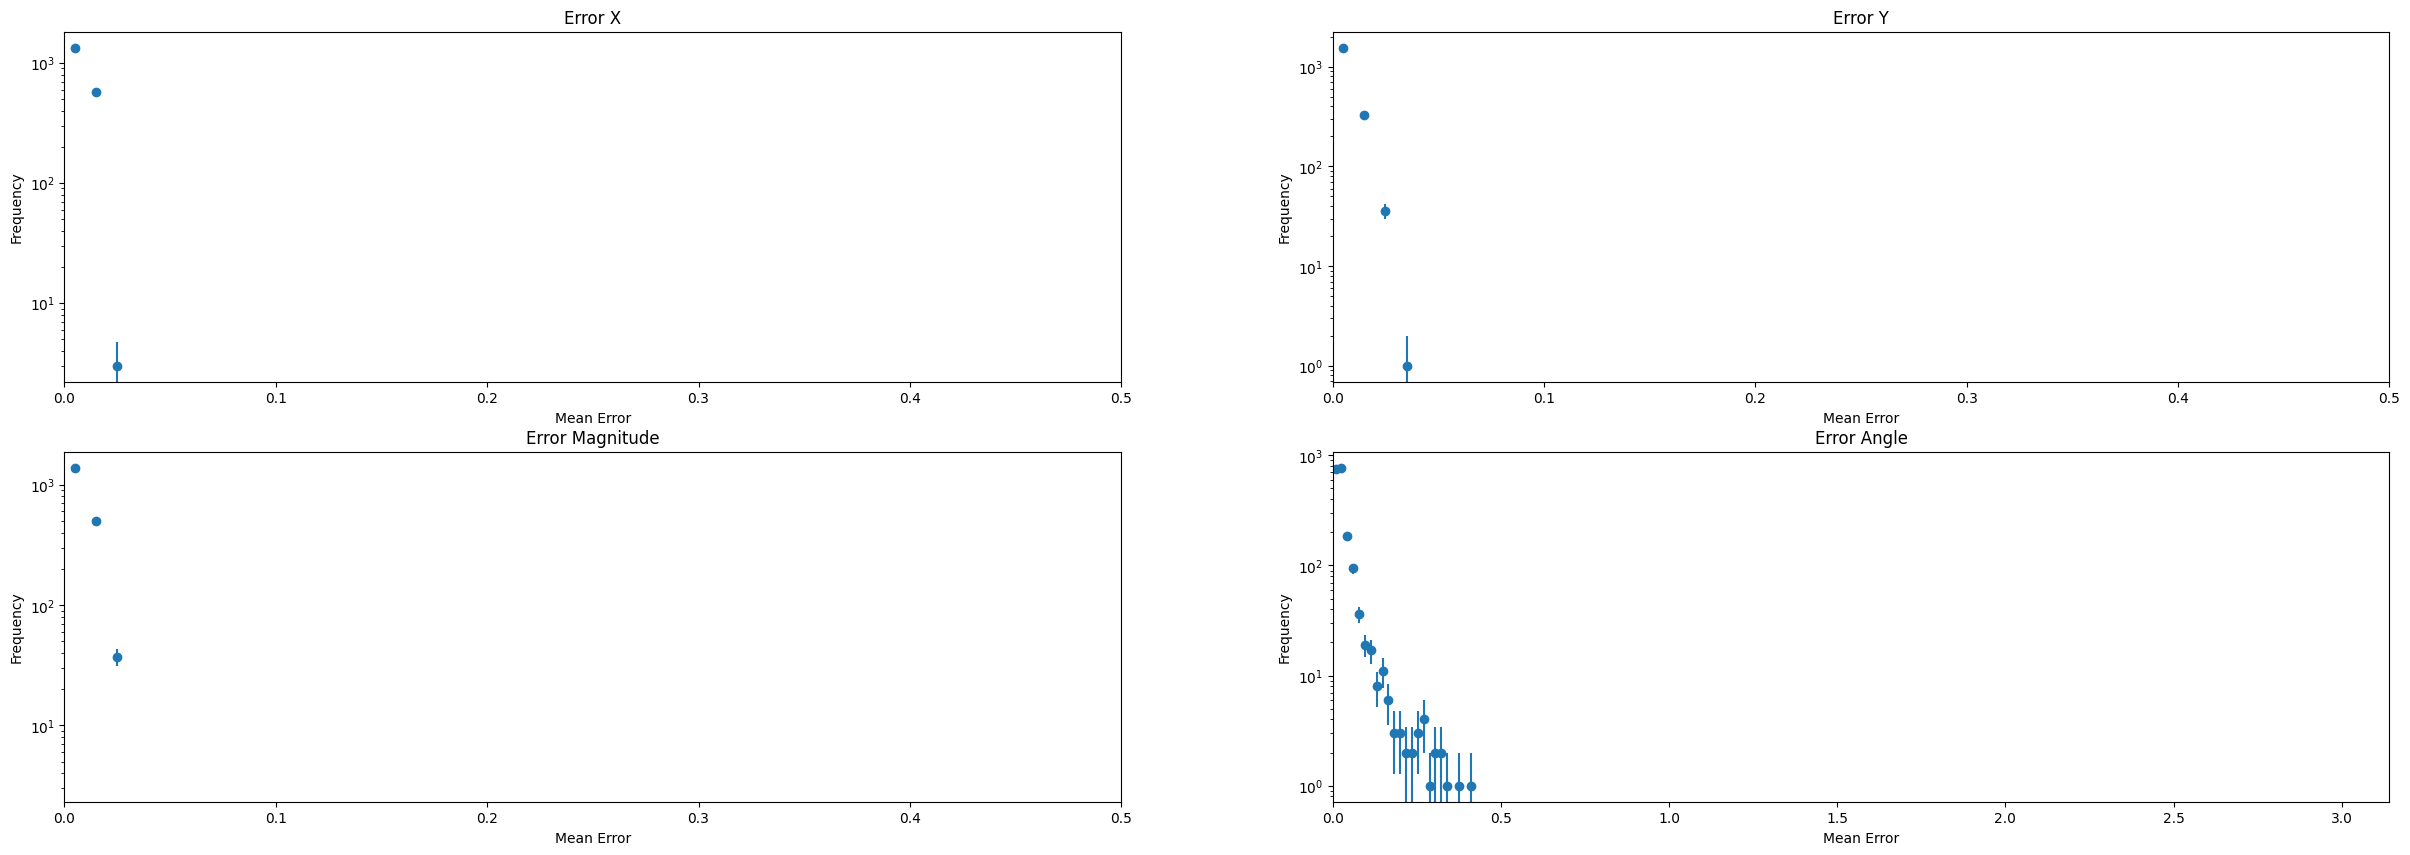

Mean error x: 0.0091117425
Mean error y: 0.0070987577
Mean error magnitude: 0.008575333
Mean error angle: 0.031112246
Mean error x std: 0.0025992764
Mean error y std: 0.004350689
Mean error magnitude std: 0.0041937525
Mean error angle std: 0.035516478


In [39]:
# median
getErrorHistograms(model, test_loader, figureOfMerit="all", metric="median")
getErrorHistograms(model, test_loader, figureOfMerit="aperture", metric="median")
getErrorHistograms(model, test_loader, figureOfMerit="yoke", metric="median")
getErrorHistograms(model, test_loader, figureOfMerit="coil", metric="median")
getErrorHistograms(model, test_loader, figureOfMerit="rest", metric="median")

-------------------------
all


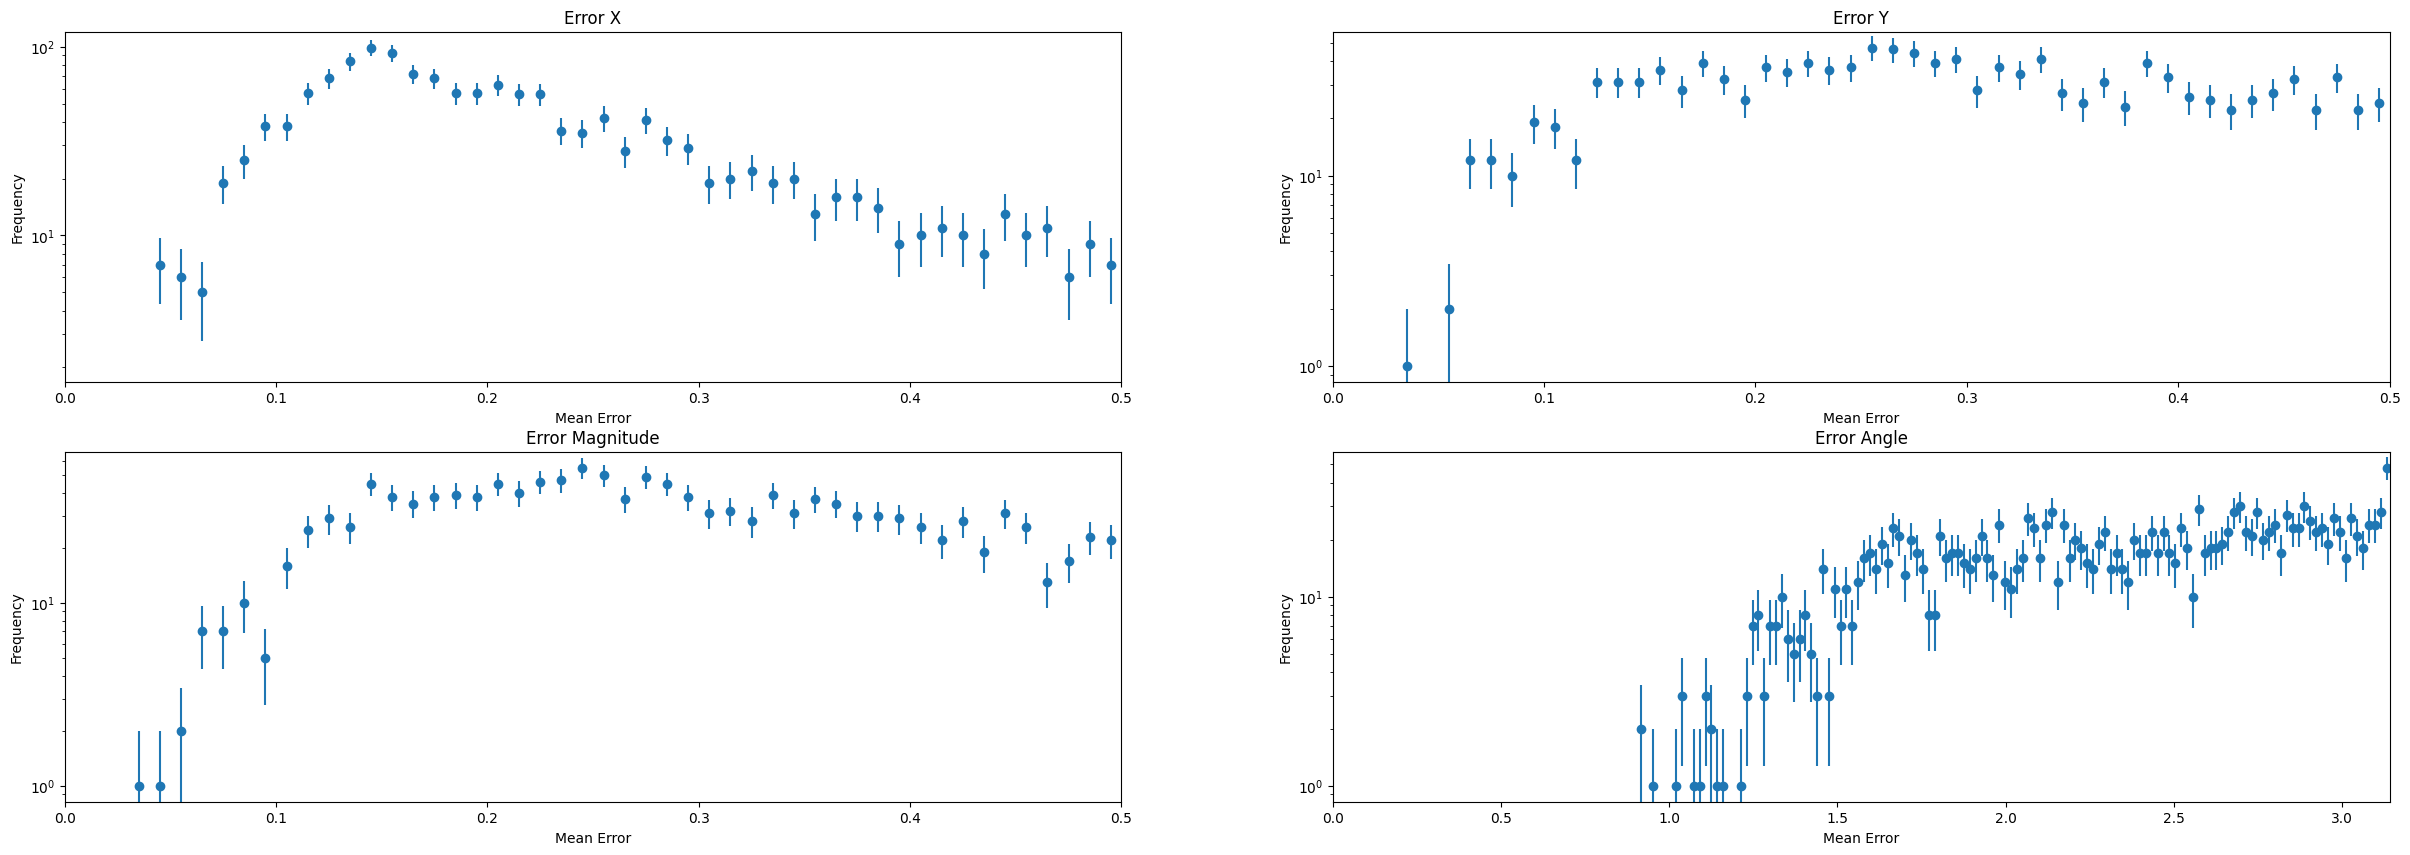

Mean error x: 0.36703685
Mean error y: 0.43353304
Mean error magnitude: 0.41915163
Mean error angle: 2.3386319
Mean error x std: 0.3175166
Mean error y std: 0.2705473
Mean error magnitude std: 0.27197003
Mean error angle std: 0.5285381
-------------------------
aperture


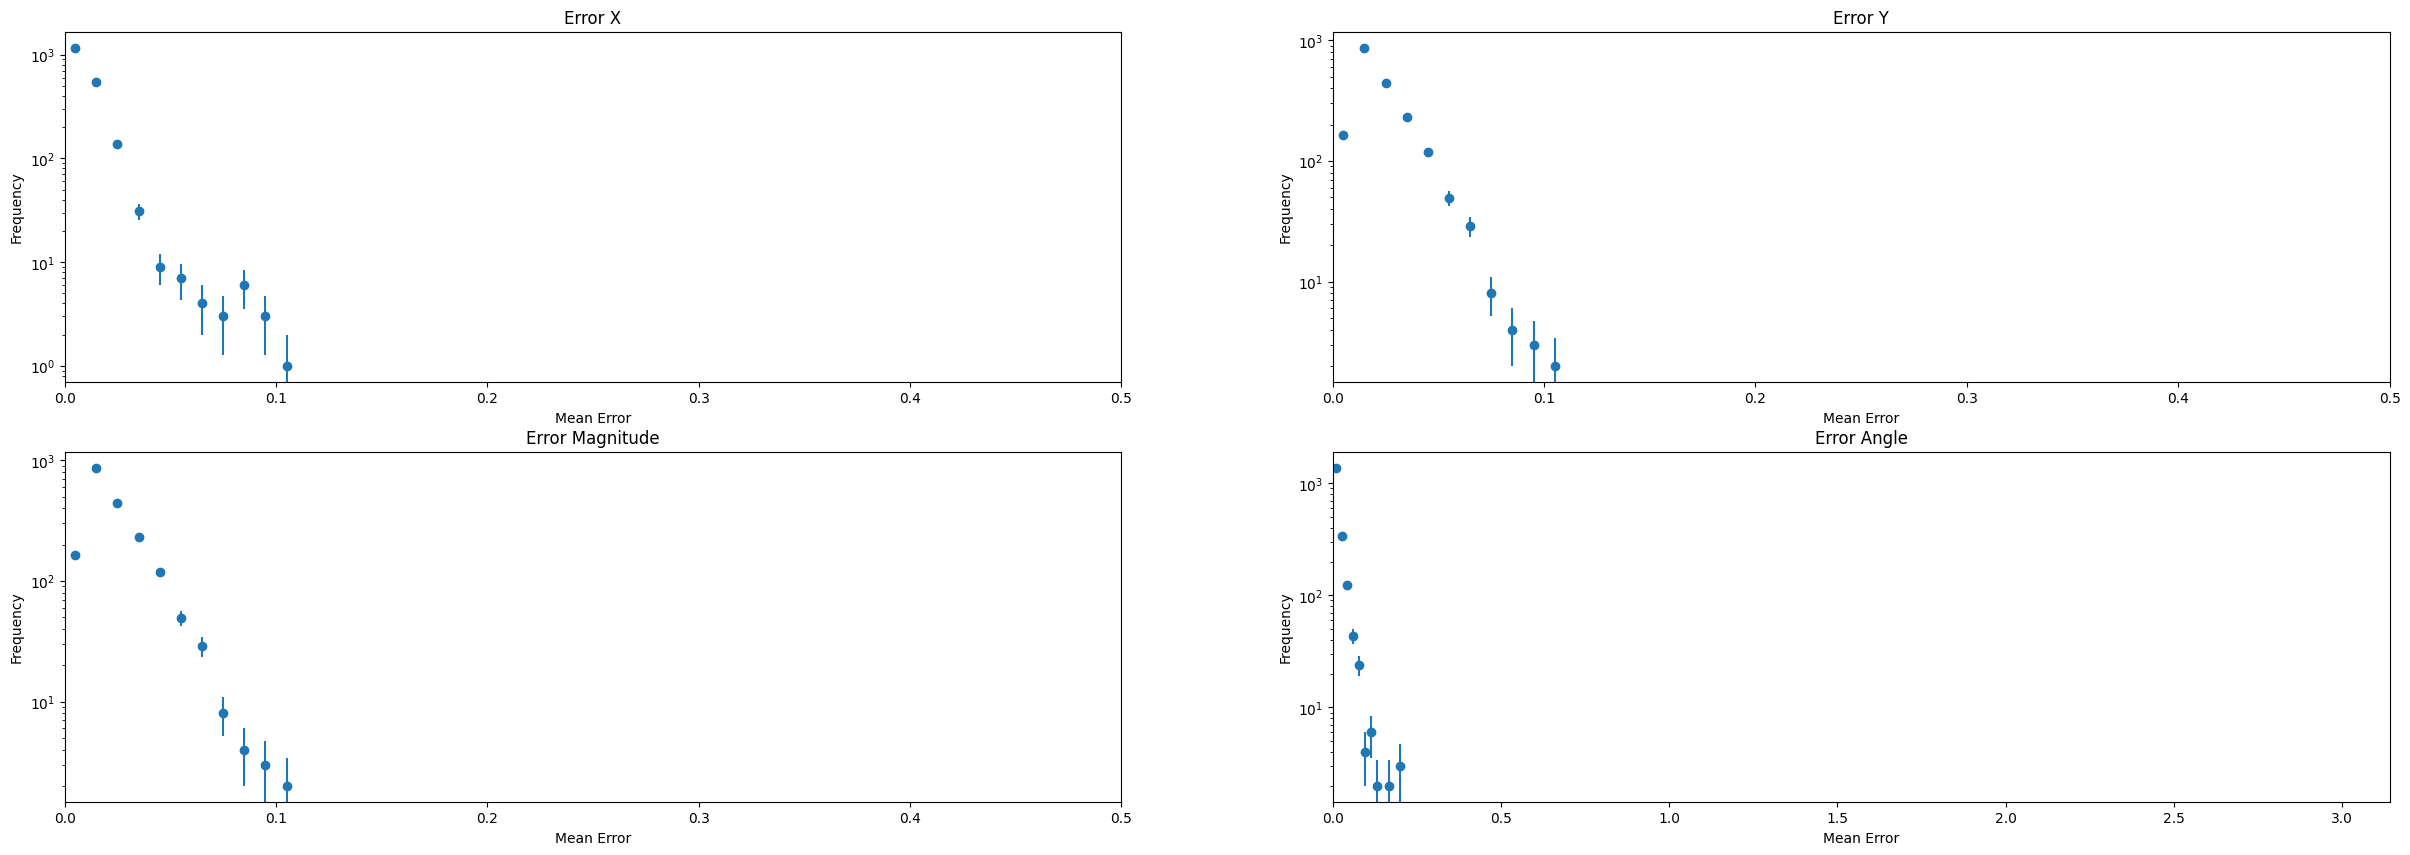

Mean error x: 0.011276092
Mean error y: 0.023042738
Mean error magnitude: 0.023046298
Mean error angle: 0.018320465
Mean error x std: 0.009842272
Mean error y std: 0.013472991
Mean error magnitude std: 0.013473698
Mean error angle std: 0.017445143
-------------------------
yoke


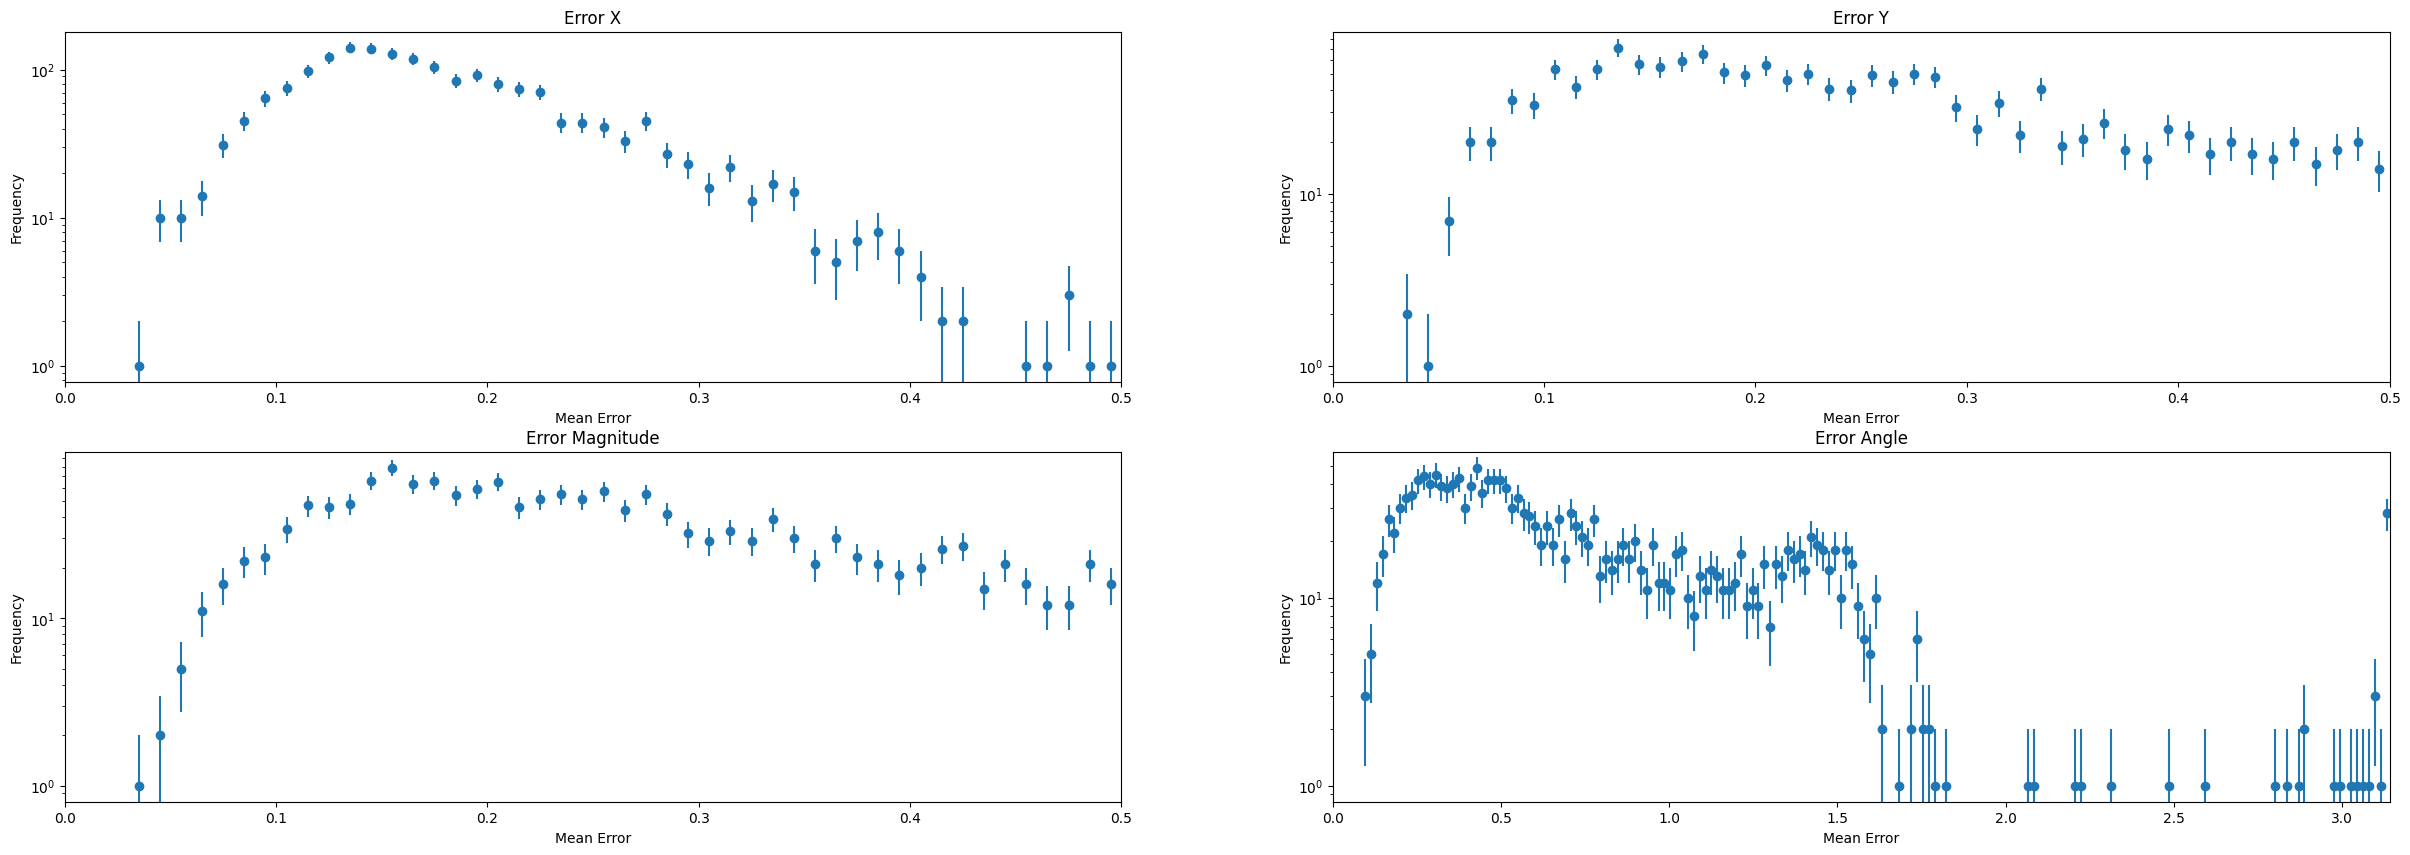

Mean error x: 0.19633467
Mean error y: 0.33400384
Mean error magnitude: 0.33416846
Mean error angle: 0.770087
Mean error x std: 0.1506277
Mean error y std: 0.24245864
Mean error magnitude std: 0.24746902
Mean error angle std: 0.5544204
-------------------------
coil


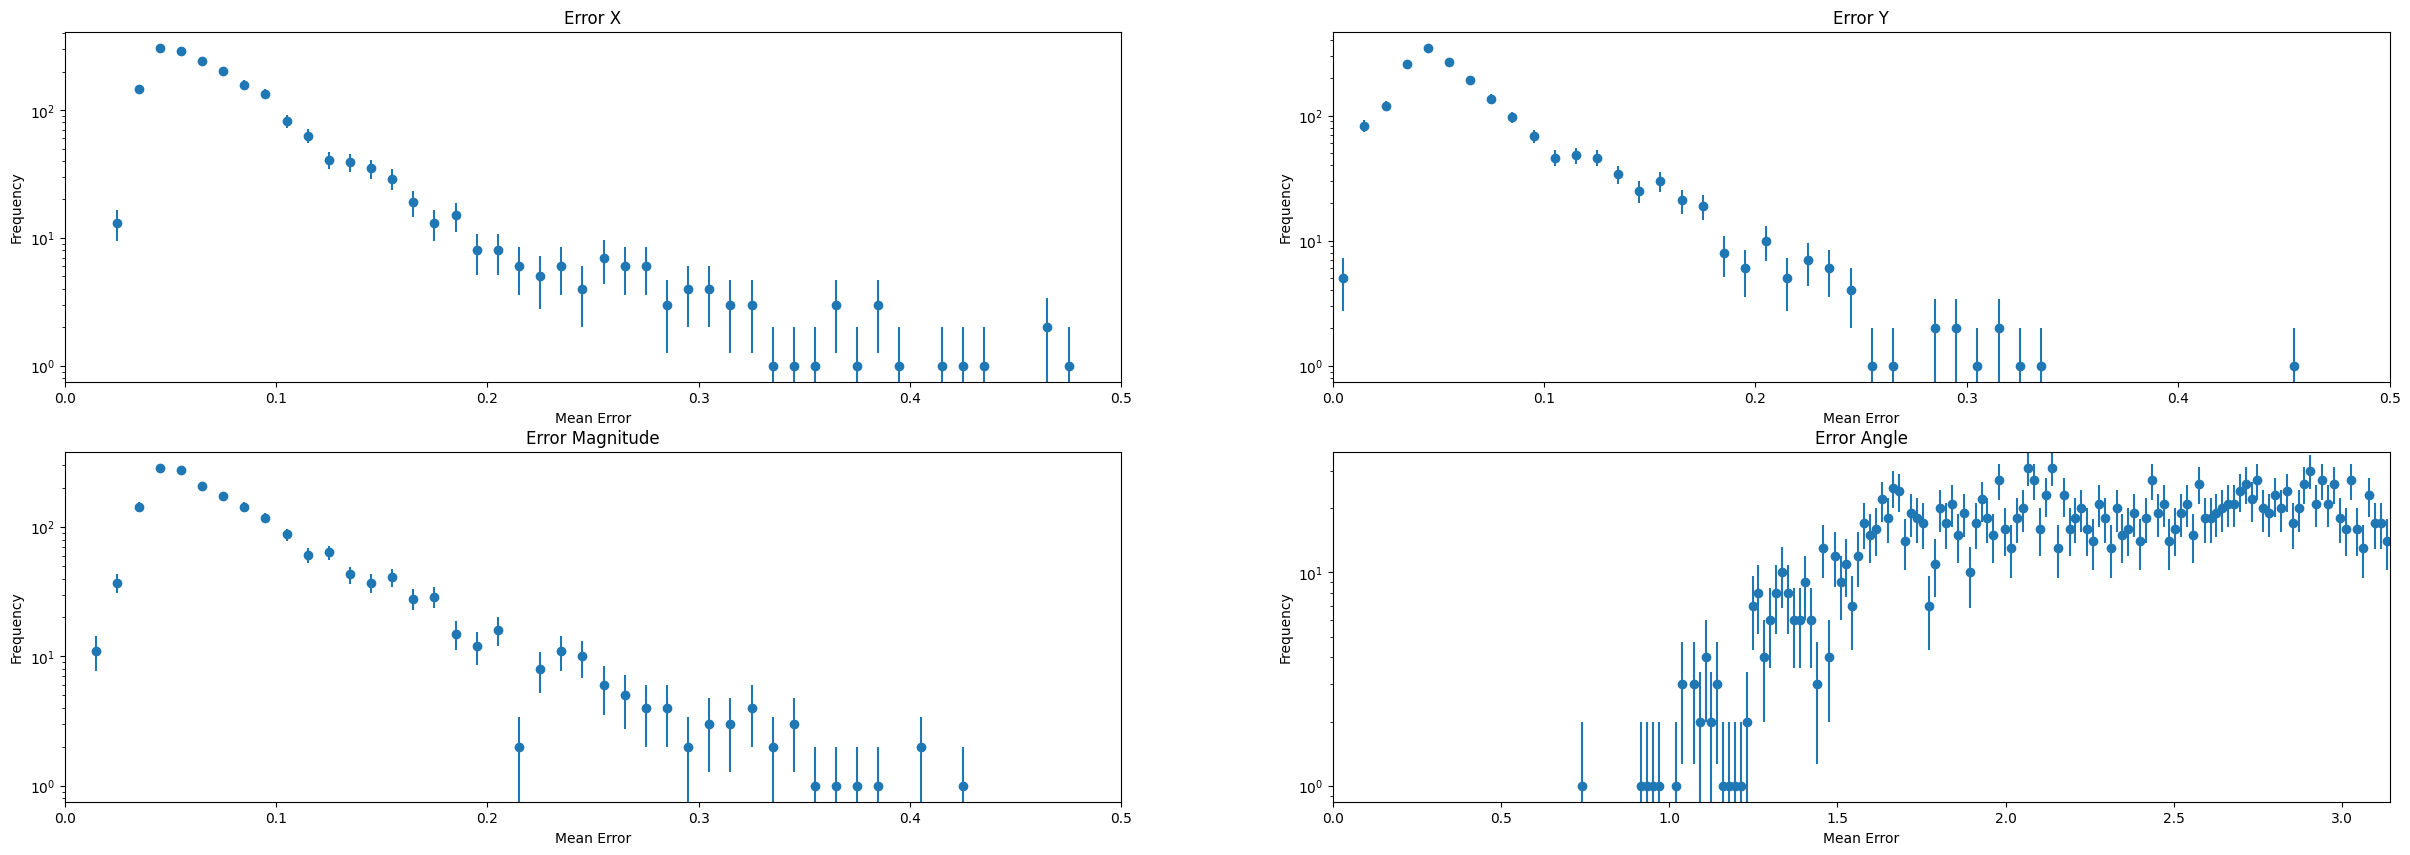

Mean error x: 0.083931096
Mean error y: 0.07688738
Mean error magnitude: 0.09428059
Mean error angle: 2.2870429
Mean error x std: 0.055597324
Mean error y std: 0.100784674
Mean error magnitude std: 0.1023387
Mean error angle std: 0.5226024
-------------------------
rest


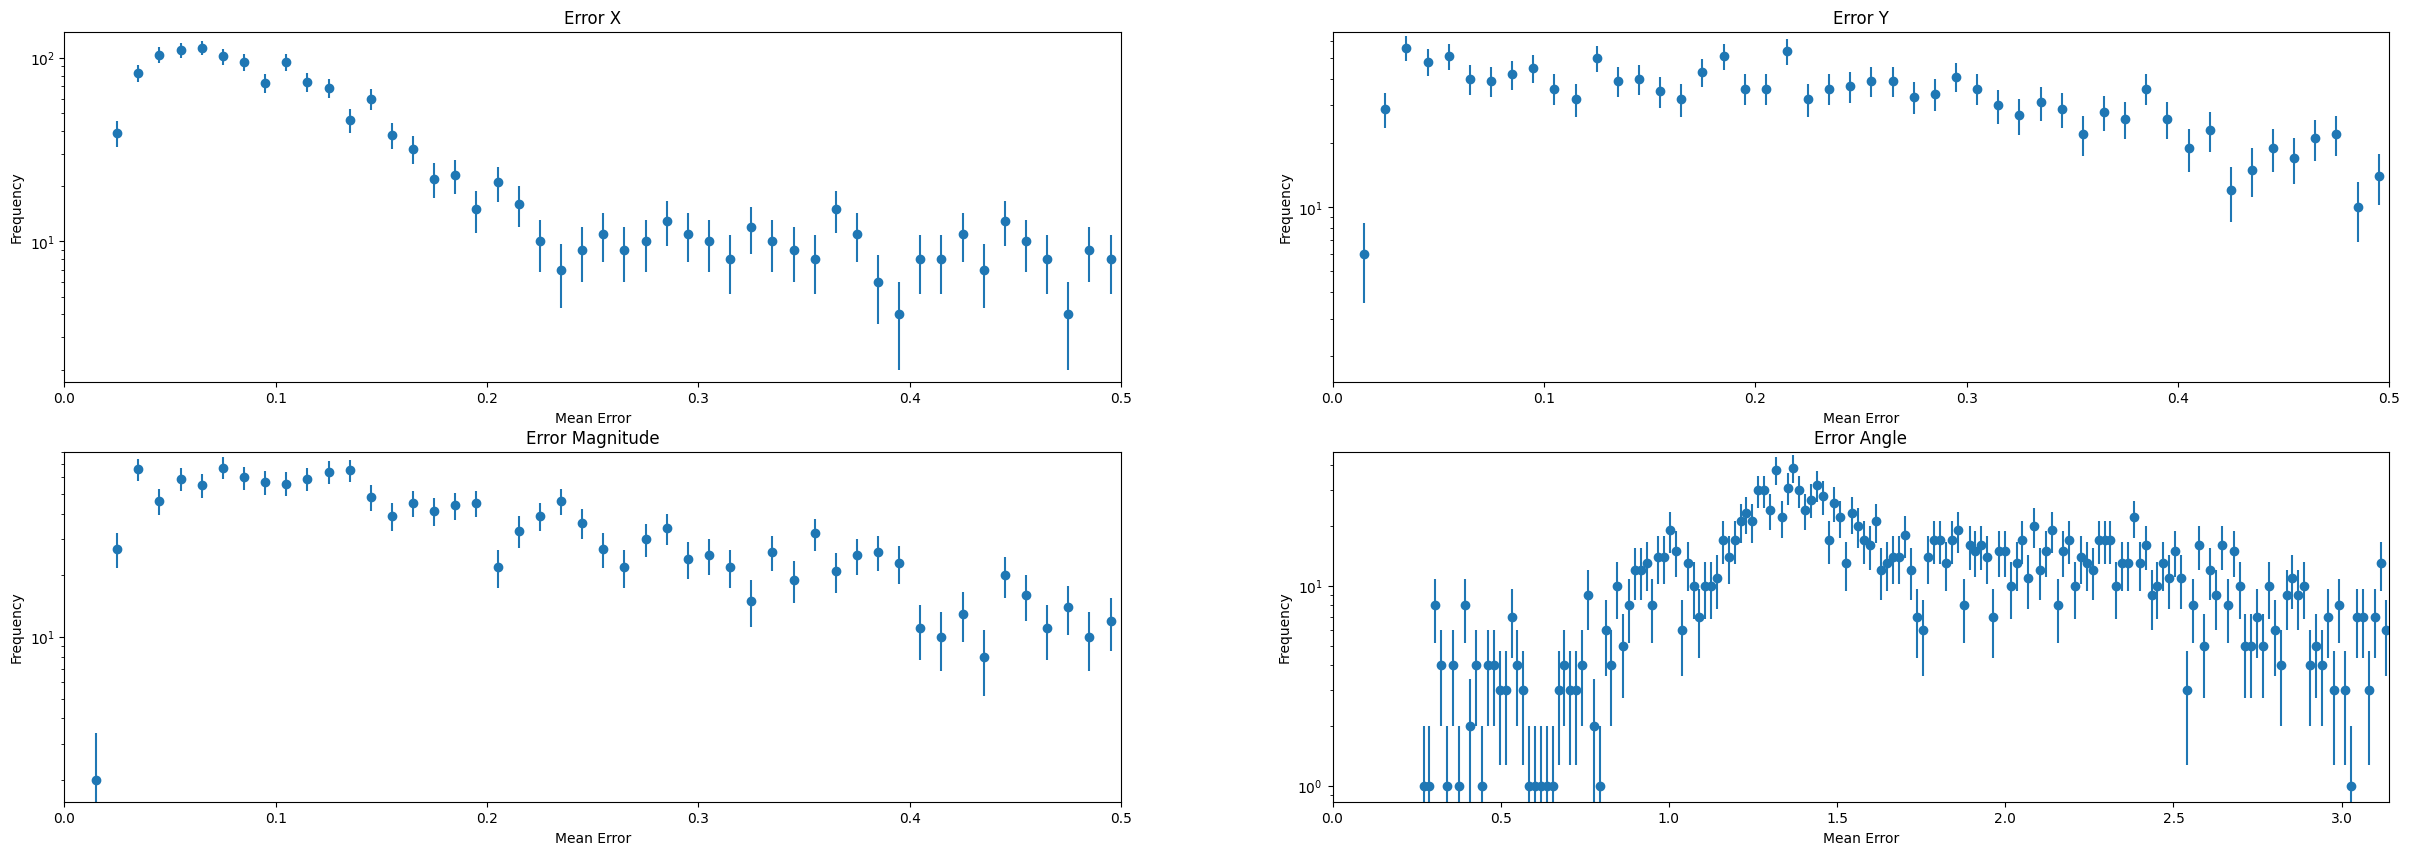

Mean error x: 0.29898998
Mean error y: 0.30750382
Mean error magnitude: 0.2770593
Mean error angle: 1.7485484
Mean error x std: 0.33210465
Mean error y std: 0.2378639
Mean error magnitude std: 0.22972928
Mean error angle std: 0.64047366


In [40]:
# max
getErrorHistograms(model, test_loader, figureOfMerit="all", metric="max")
getErrorHistograms(model, test_loader, figureOfMerit="aperture", metric="max")
getErrorHistograms(model, test_loader, figureOfMerit="yoke", metric="max")
getErrorHistograms(model, test_loader, figureOfMerit="coil", metric="max")
getErrorHistograms(model, test_loader, figureOfMerit="rest", metric="max")

-------------------------
all


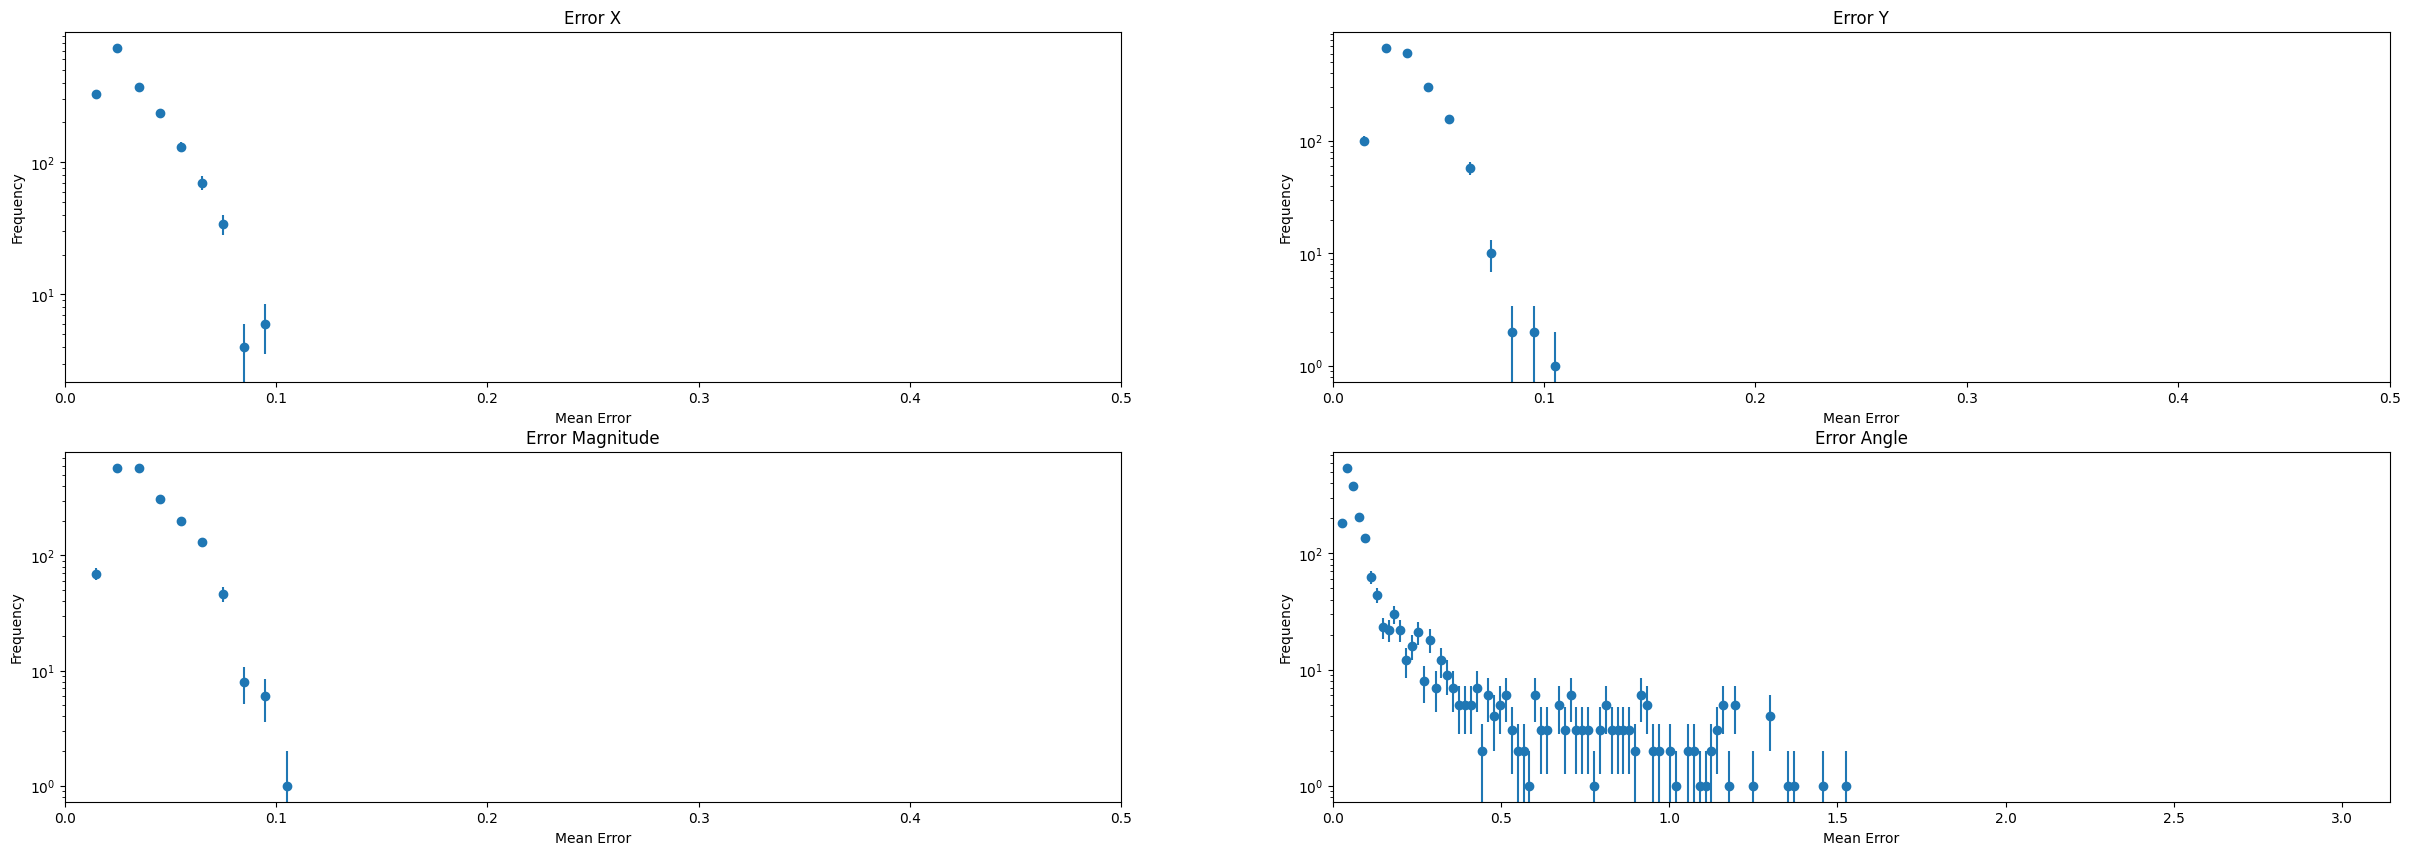

perc95  error x: 0.03241735510414097
perc95  error y: 0.03485002982924924
perc95  error magnitude: 0.03833424627557784
perc95  error angle: 0.13694841476157296
perc95  error x std: 0.014479869727988473
perc95  error y std: 0.011985682972960498
perc95  error magnitude std: 0.014430575516458745
perc95  error angle std: 0.21363791819124345
-------------------------
aperture


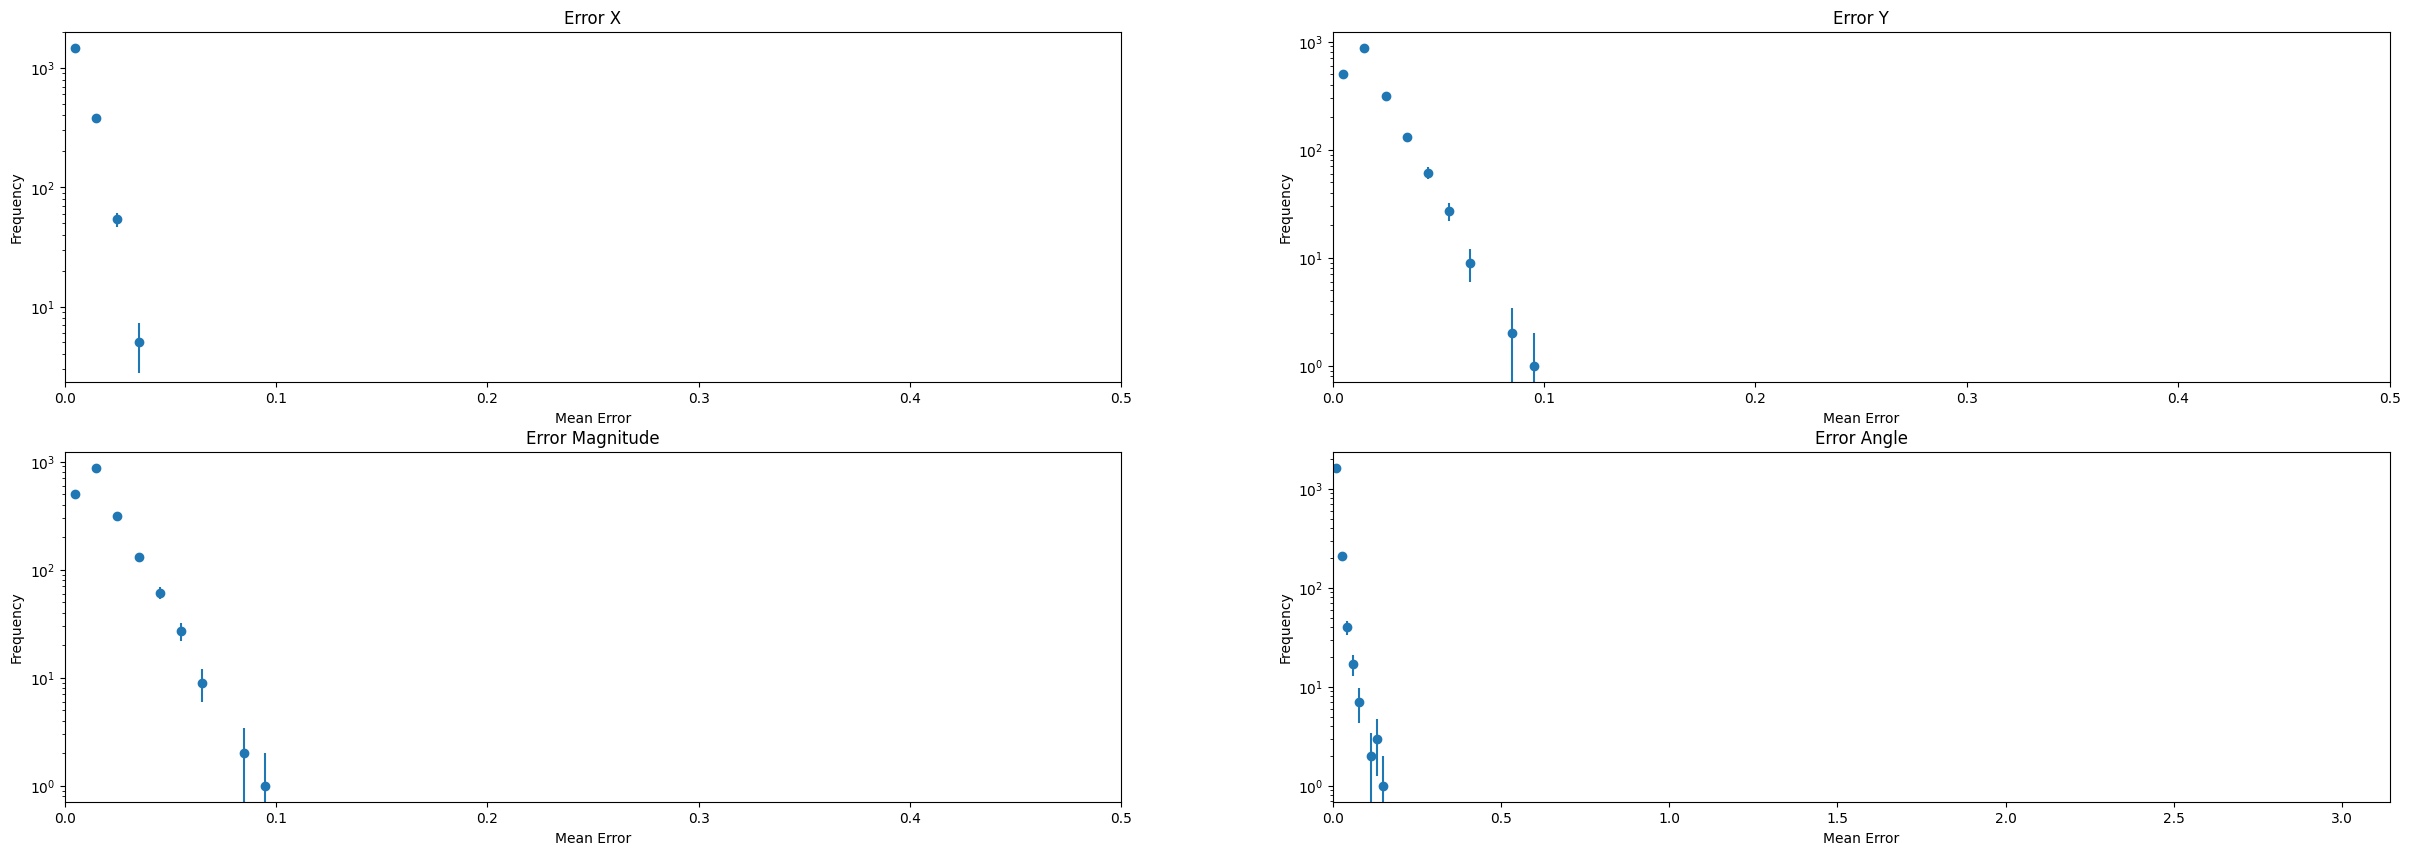

perc95  error x: 0.00737540606596667
perc95  error y: 0.01740218437645429
perc95  error magnitude: 0.01740296984169011
perc95  error angle: 0.012026461468388634
perc95  error x std: 0.0048864942251020185
perc95  error y std: 0.011109614968611023
perc95  error magnitude std: 0.011109413841920952
perc95  error angle std: 0.0116794957294854
-------------------------
yoke


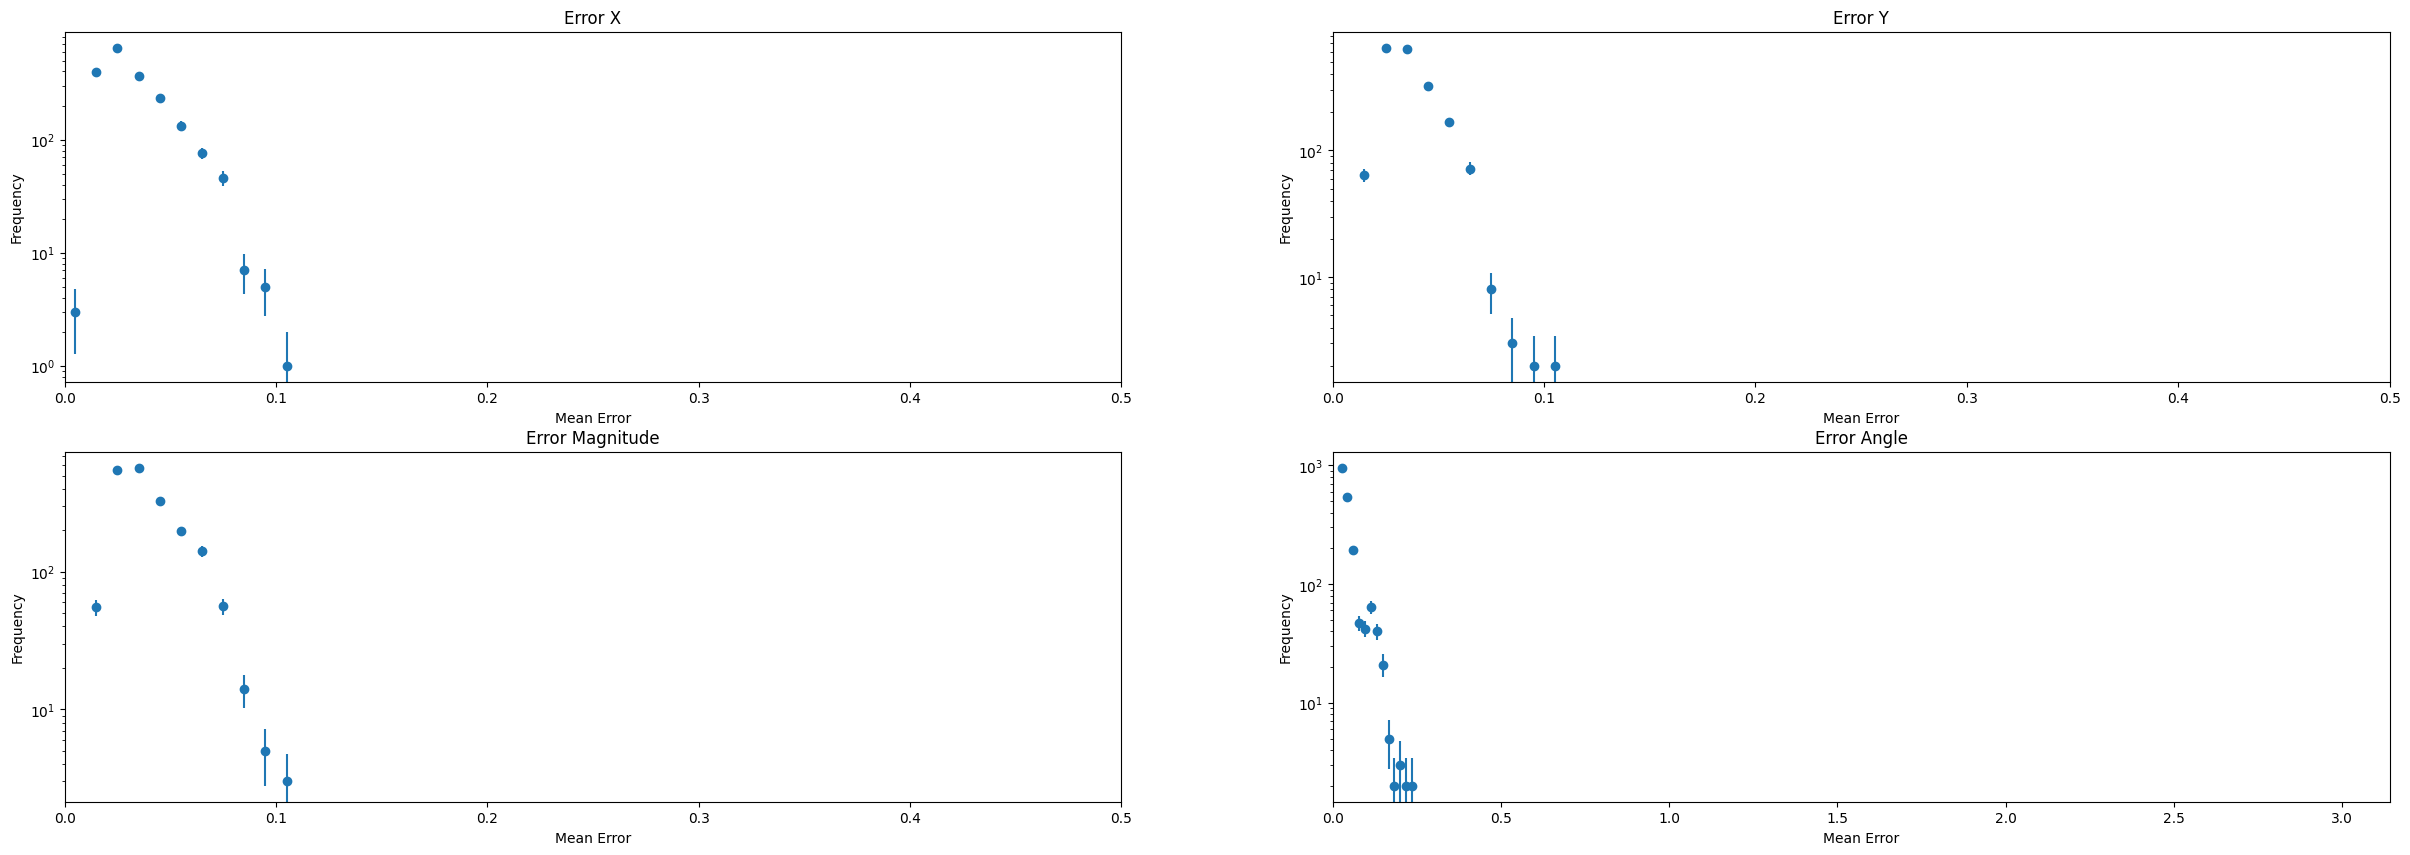

perc95  error x: 0.032377664085215654
perc95  error y: 0.035930430787266224
perc95  error magnitude: 0.03934524646475134
perc95  error angle: 0.045586236113061486
perc95  error x std: 0.015642925051452813
perc95  error y std: 0.012115370827484973
perc95  error magnitude std: 0.014913694295029322
perc95  error angle std: 0.029222978537715726
-------------------------
coil


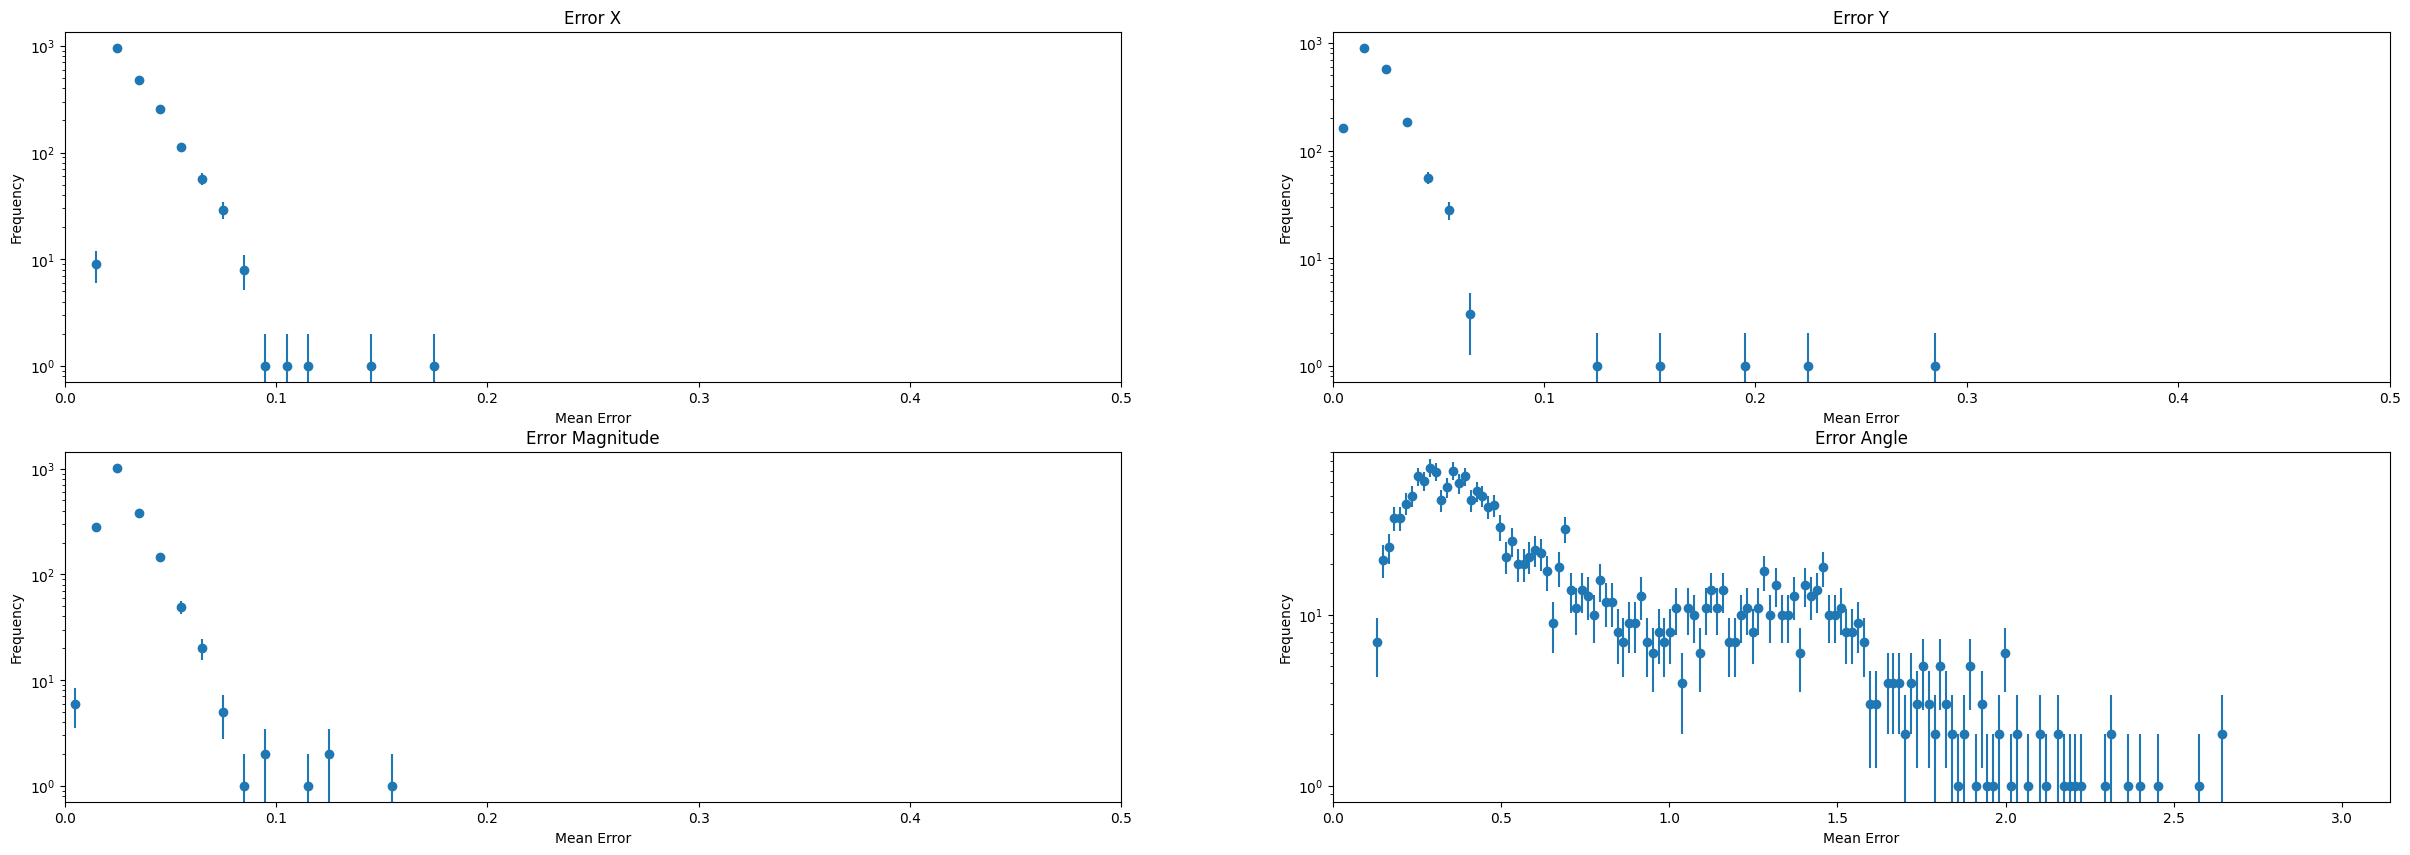

perc95  error x: 0.03443512935589144
perc95  error y: 0.021087426779182947
perc95  error magnitude: 0.028500678110212892
perc95  error angle: 0.6646381231707827
perc95  error x std: 0.013083306336220773
perc95  error y std: 0.013436061969335599
perc95  error magnitude std: 0.011169951599717683
perc95  error angle std: 0.4763211928263957
-------------------------
rest


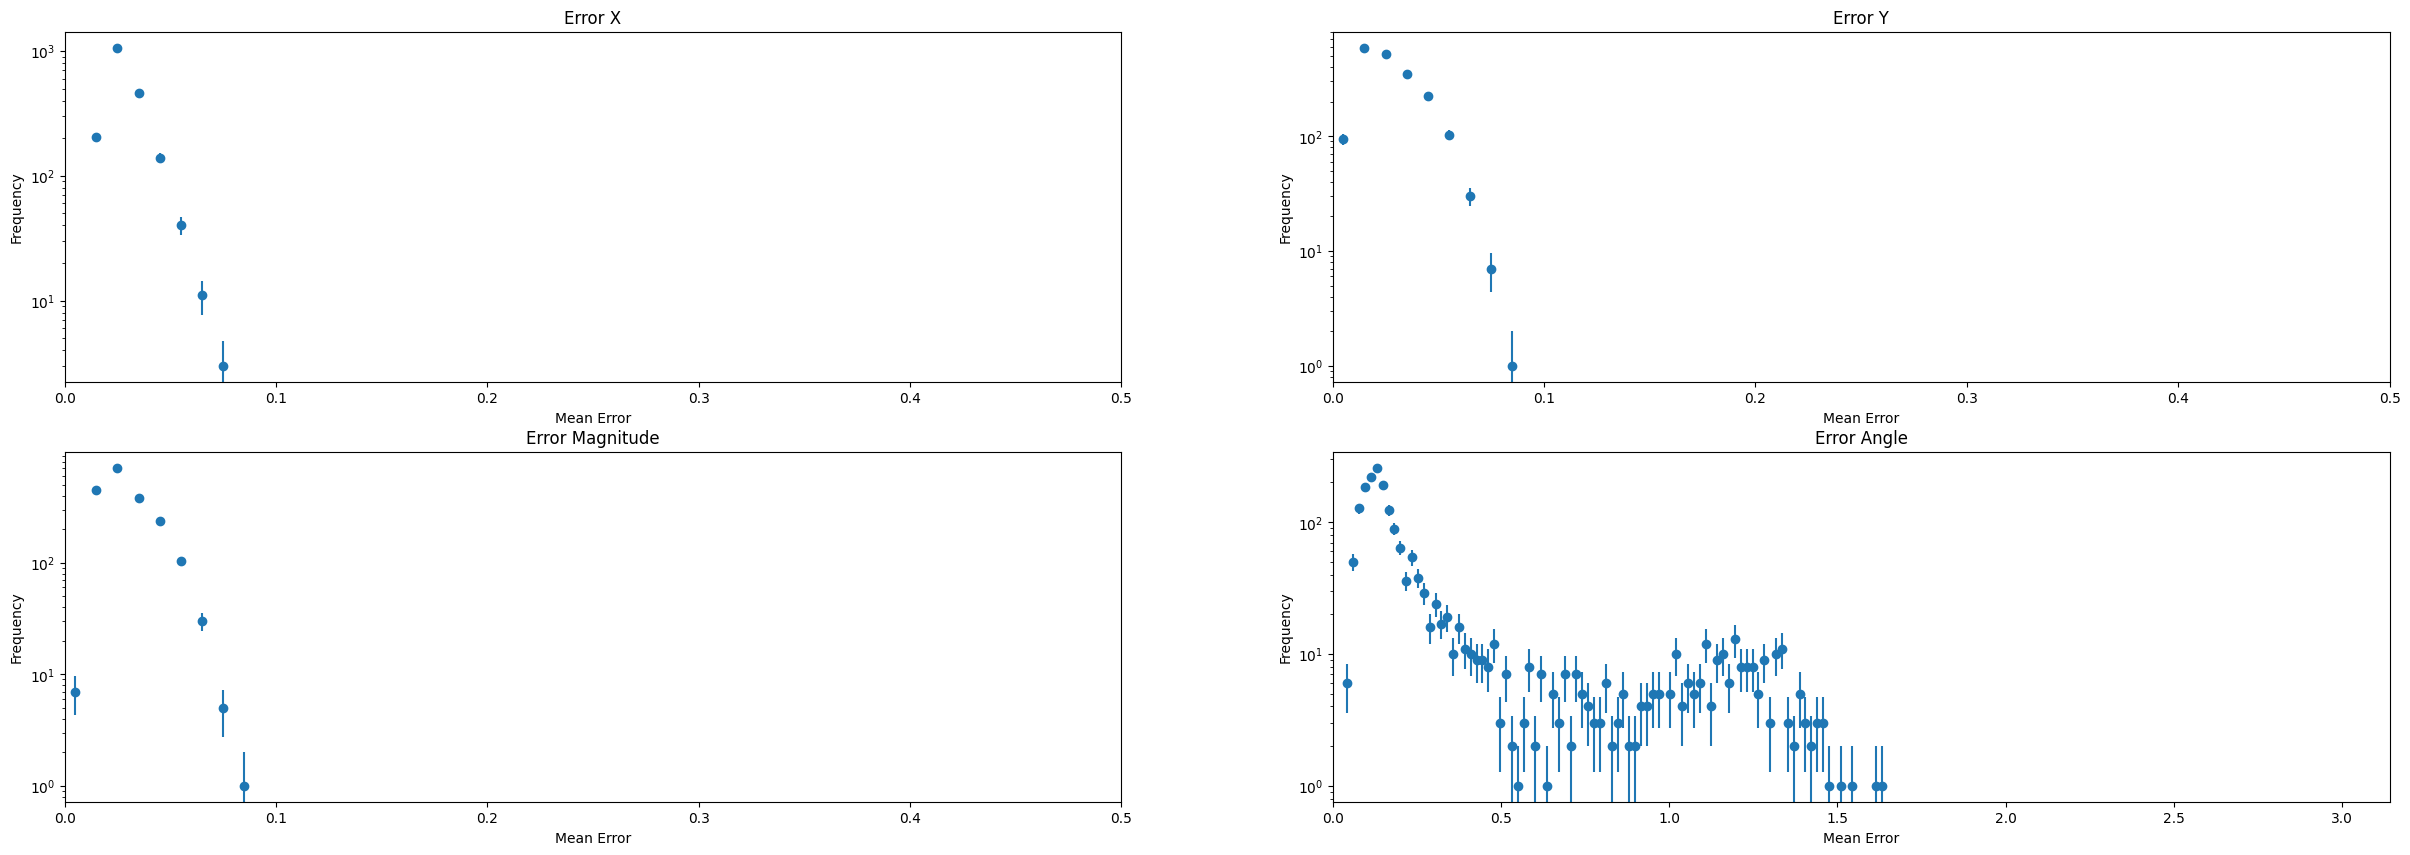

perc95  error x: 0.028444398189506795
perc95  error y: 0.027504093780189566
perc95  error magnitude: 0.029381067144689334
perc95  error angle: 0.2928836213114359
perc95  error x std: 0.00867890872634346
perc95  error y std: 0.013528054355632474
perc95  error magnitude std: 0.01212650065382671
perc95  error angle std: 0.33661972028114057


In [58]:
# 95th percentile
getErrorHistograms(model, test_loader, figureOfMerit="all", metric="perc95")
getErrorHistograms(model, test_loader, figureOfMerit="aperture", metric="perc95")
getErrorHistograms(model, test_loader, figureOfMerit="yoke", metric="perc95")
getErrorHistograms(model, test_loader, figureOfMerit="coil", metric="perc95")
getErrorHistograms(model, test_loader, figureOfMerit="rest", metric="perc95")

-------------------------
aperture


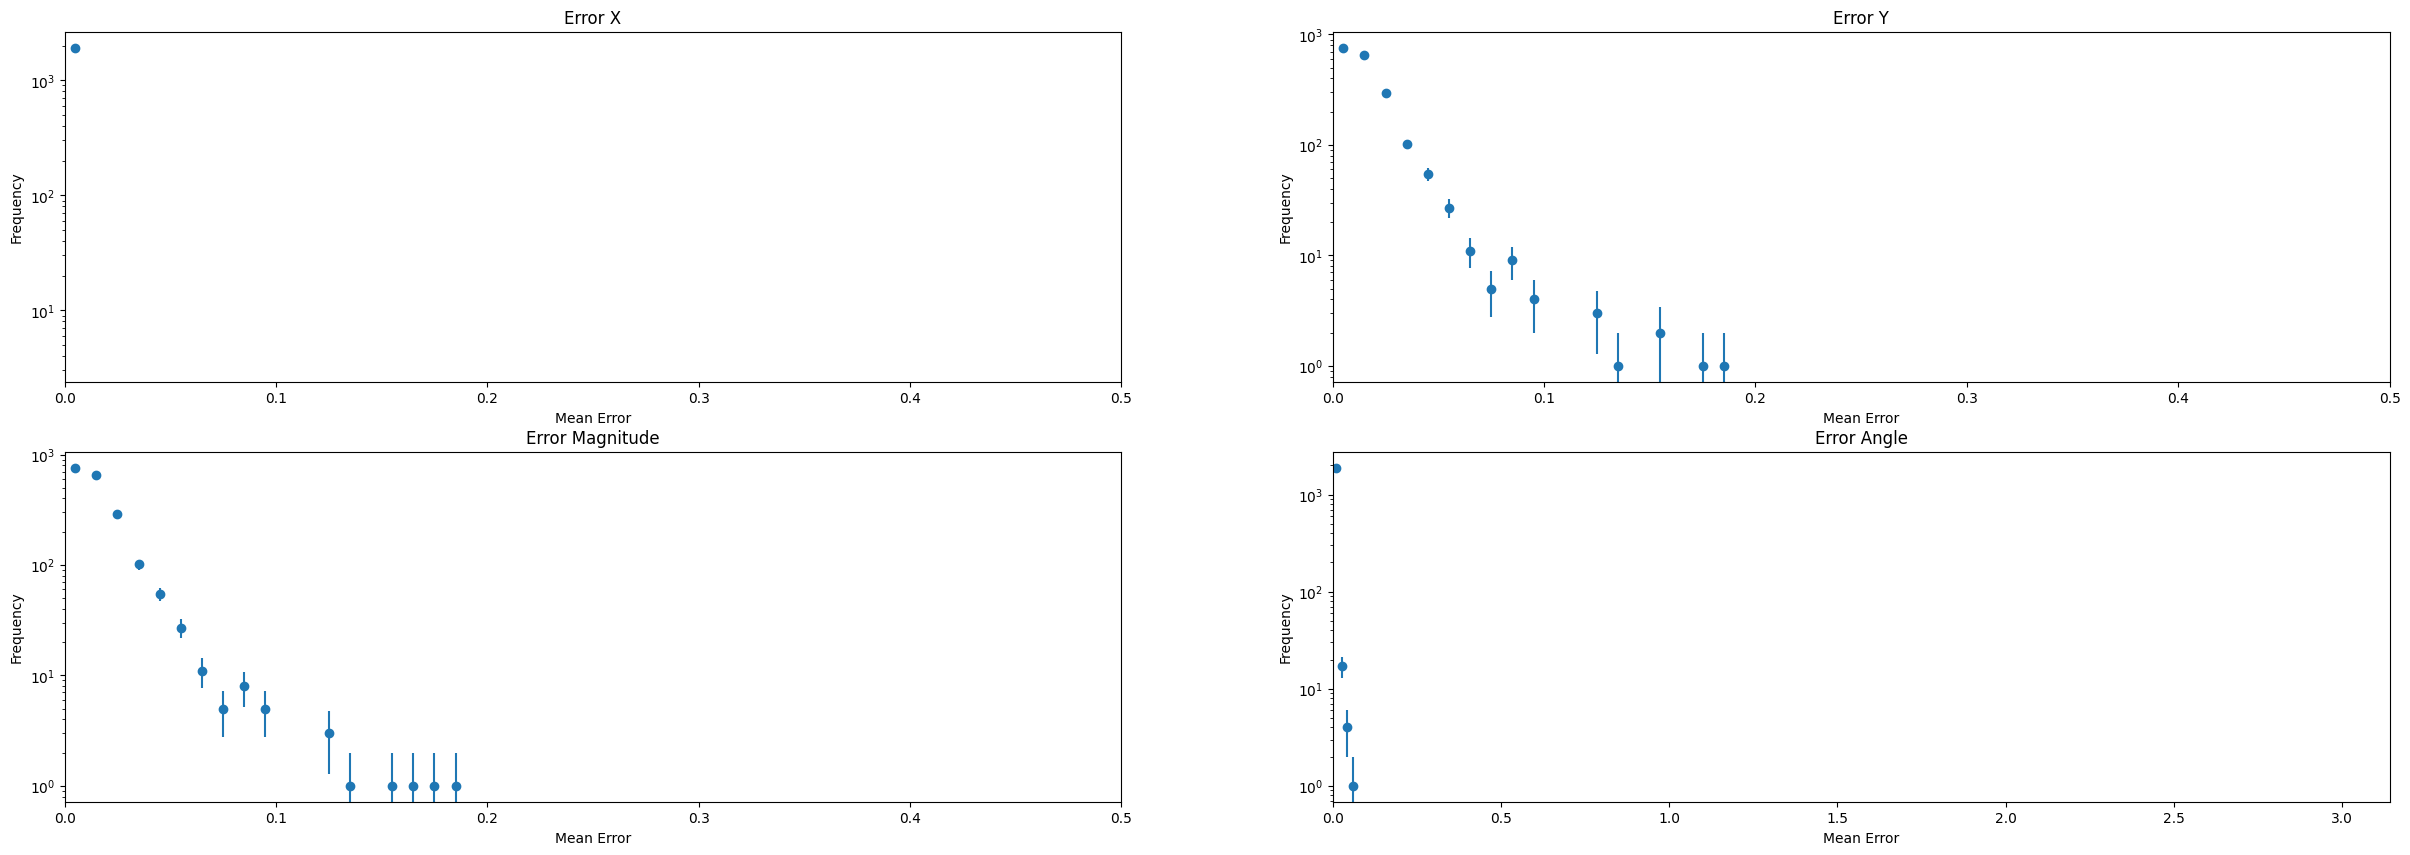

mean  error x: 0.0
mean  error y: 0.016699016
mean  error magnitude: 0.016707988
mean  error angle: 0.0030521725
mean  error x std: 0.0
mean  error y std: 0.015681176
mean  error magnitude std: 0.015723893
mean  error angle std: 0.0036736496
-------------------------
aperture


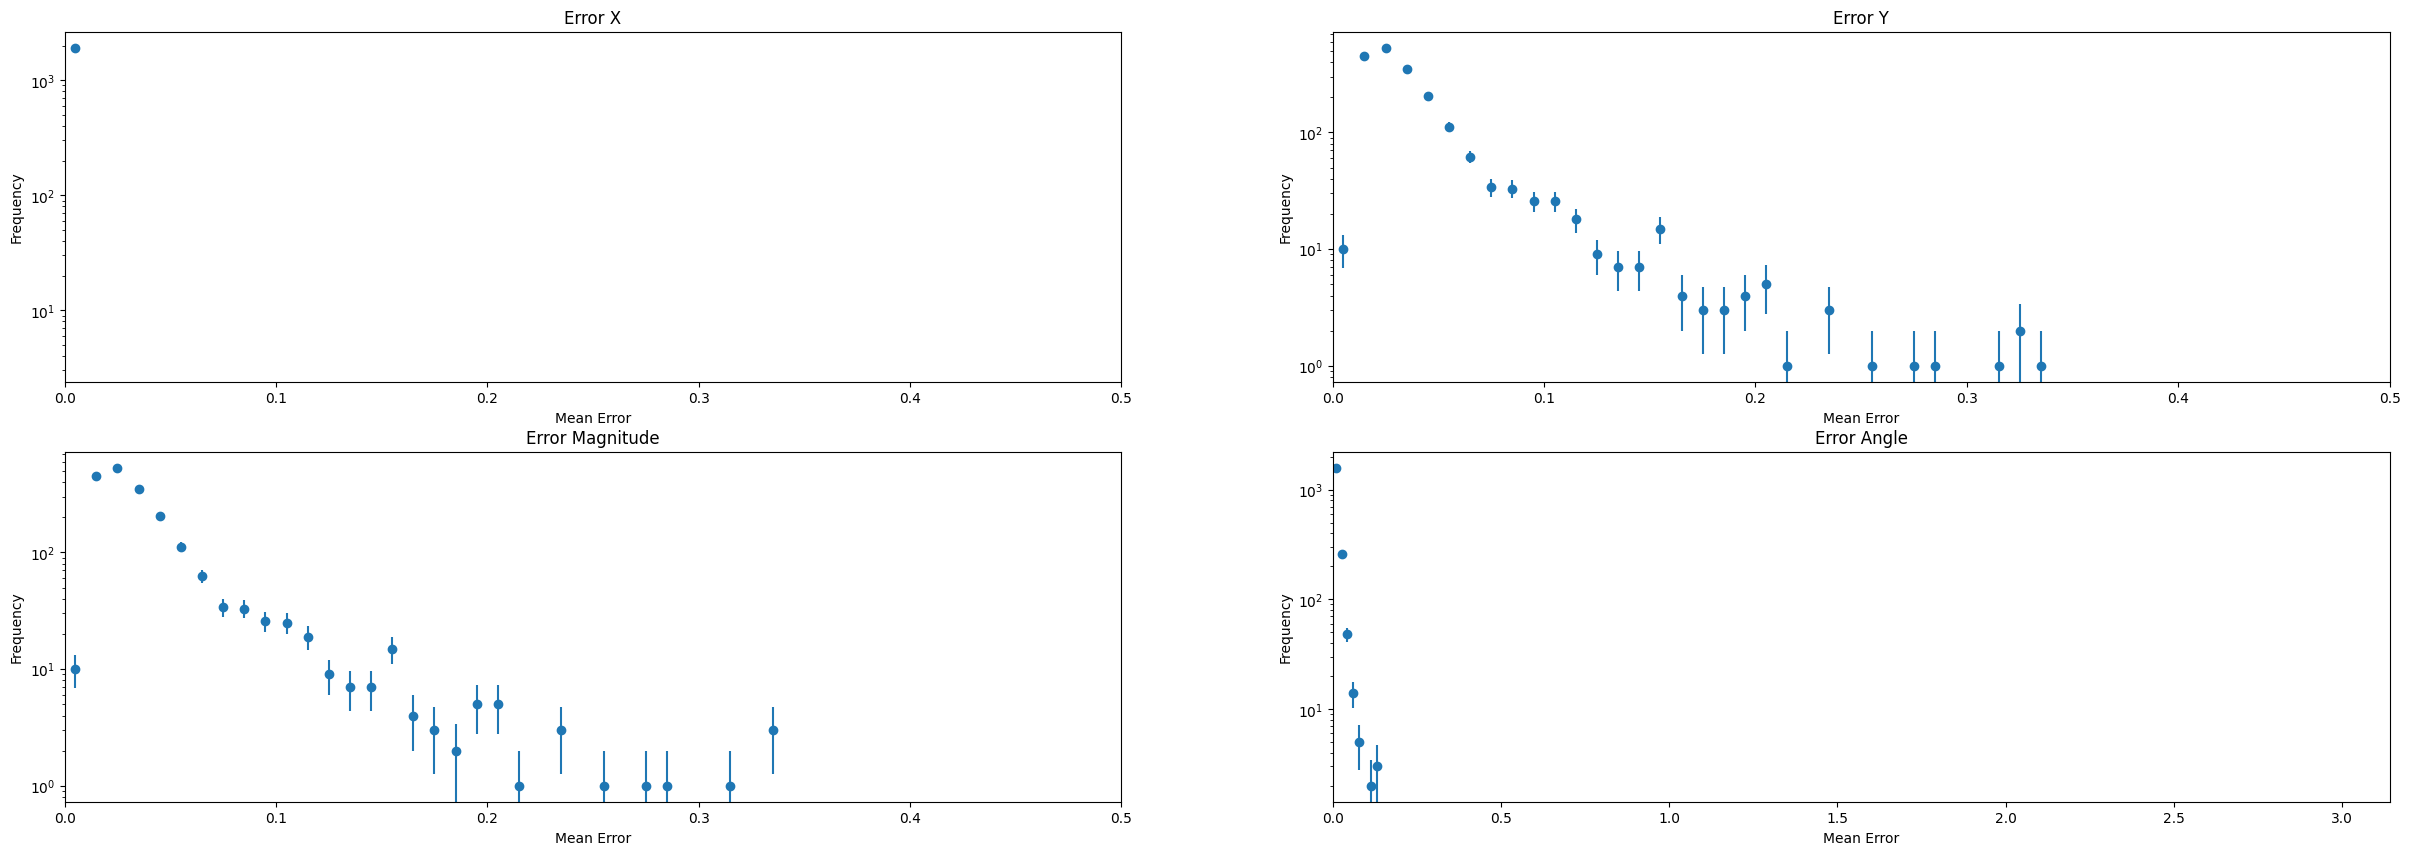

max  error x: 0.0
max  error y: 0.039747637
max  error magnitude: 0.039758164
max  error angle: 0.0116631705
max  error x std: 0.0
max  error y std: 0.034824036
max  error magnitude std: 0.03486235
max  error angle std: 0.011105924


In [84]:
# mean and max of aperture for normalization to field in 0,0
getErrorHistograms(model, test_loader, figureOfMerit="aperture", metric="mean", norm="zero")
getErrorHistograms(model, test_loader, figureOfMerit="aperture", metric="max", norm="zero")
getErrorHistograms(model, test_loader, figureOfMerit="aperture", metric="max", norm="zeroonly")

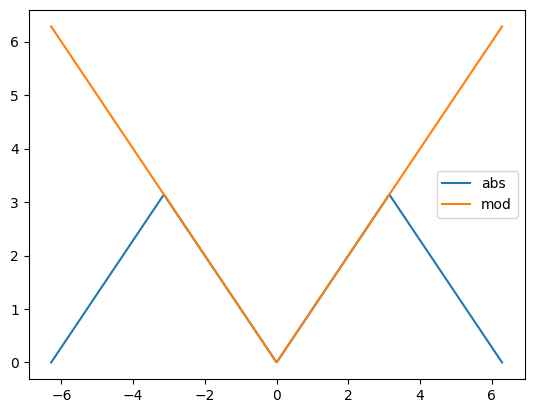

In [9]:
x = np.linspace(-2*np.pi, 2*np.pi, 628)
# get distance to any multiple of pi from any direction
y1 = abs((x + np.pi) % (2*np.pi) - np.pi)
# change to degree
y3 = np.abs(x)

plt.plot(x, y1, label="abs")
# plt.plot(x, y2, label="deg")
plt.plot(x, y3, label="mod")
plt.legend()
plt.show()

In [10]:
# load errors.pkl into a dictionary
with open("../errors.pkl", "rb") as f:
    error_dict = pickle.load(f)
print(error_dict.keys())
print(error_dict["aperture"].keys())
print(len(error_dict["aperture"]["x"]))

dict_keys(['aperture', 'magnet', 'outer'])
dict_keys(['x', 'y', 'mag', 'ang'])
66


aperture
Mean error x: 2.099520399570465
Mean error y: 2.1953653504593036
Mean error magnitude: 3.060611666767371
Mean error angle: 0.8852507207649095
Mean error x std: 0.46914292131225405
Mean error y std: 0.45502320083872133
Mean error magnitude std: 0.6540246782194338
Mean error angle std: 0.1330755260587568


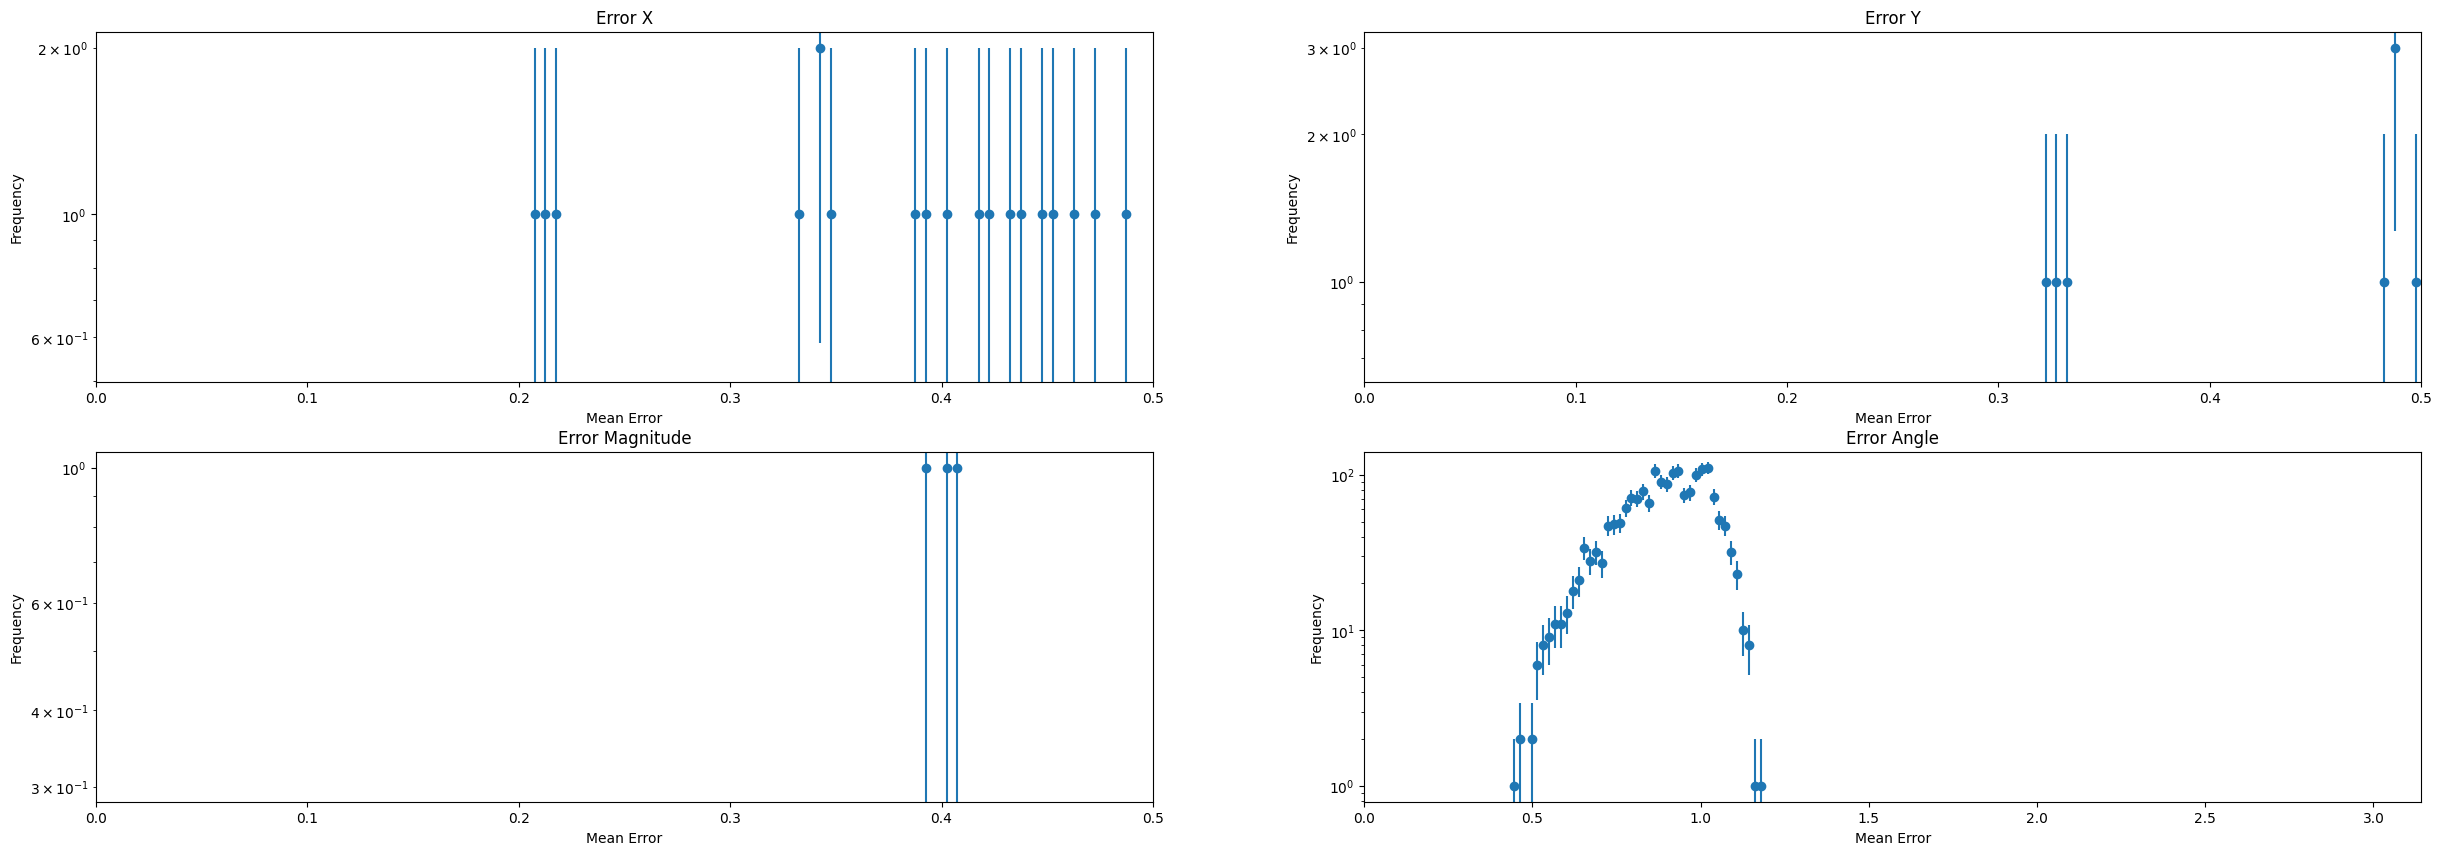

magnet
Mean error x: 2.099520399570465
Mean error y: 2.1953653504593036
Mean error magnitude: 3.060611666767371
Mean error angle: 0.8852507207649095
Mean error x std: 0.46914292131225405
Mean error y std: 0.45502320083872133
Mean error magnitude std: 0.6540246782194338
Mean error angle std: 0.1330755260587568


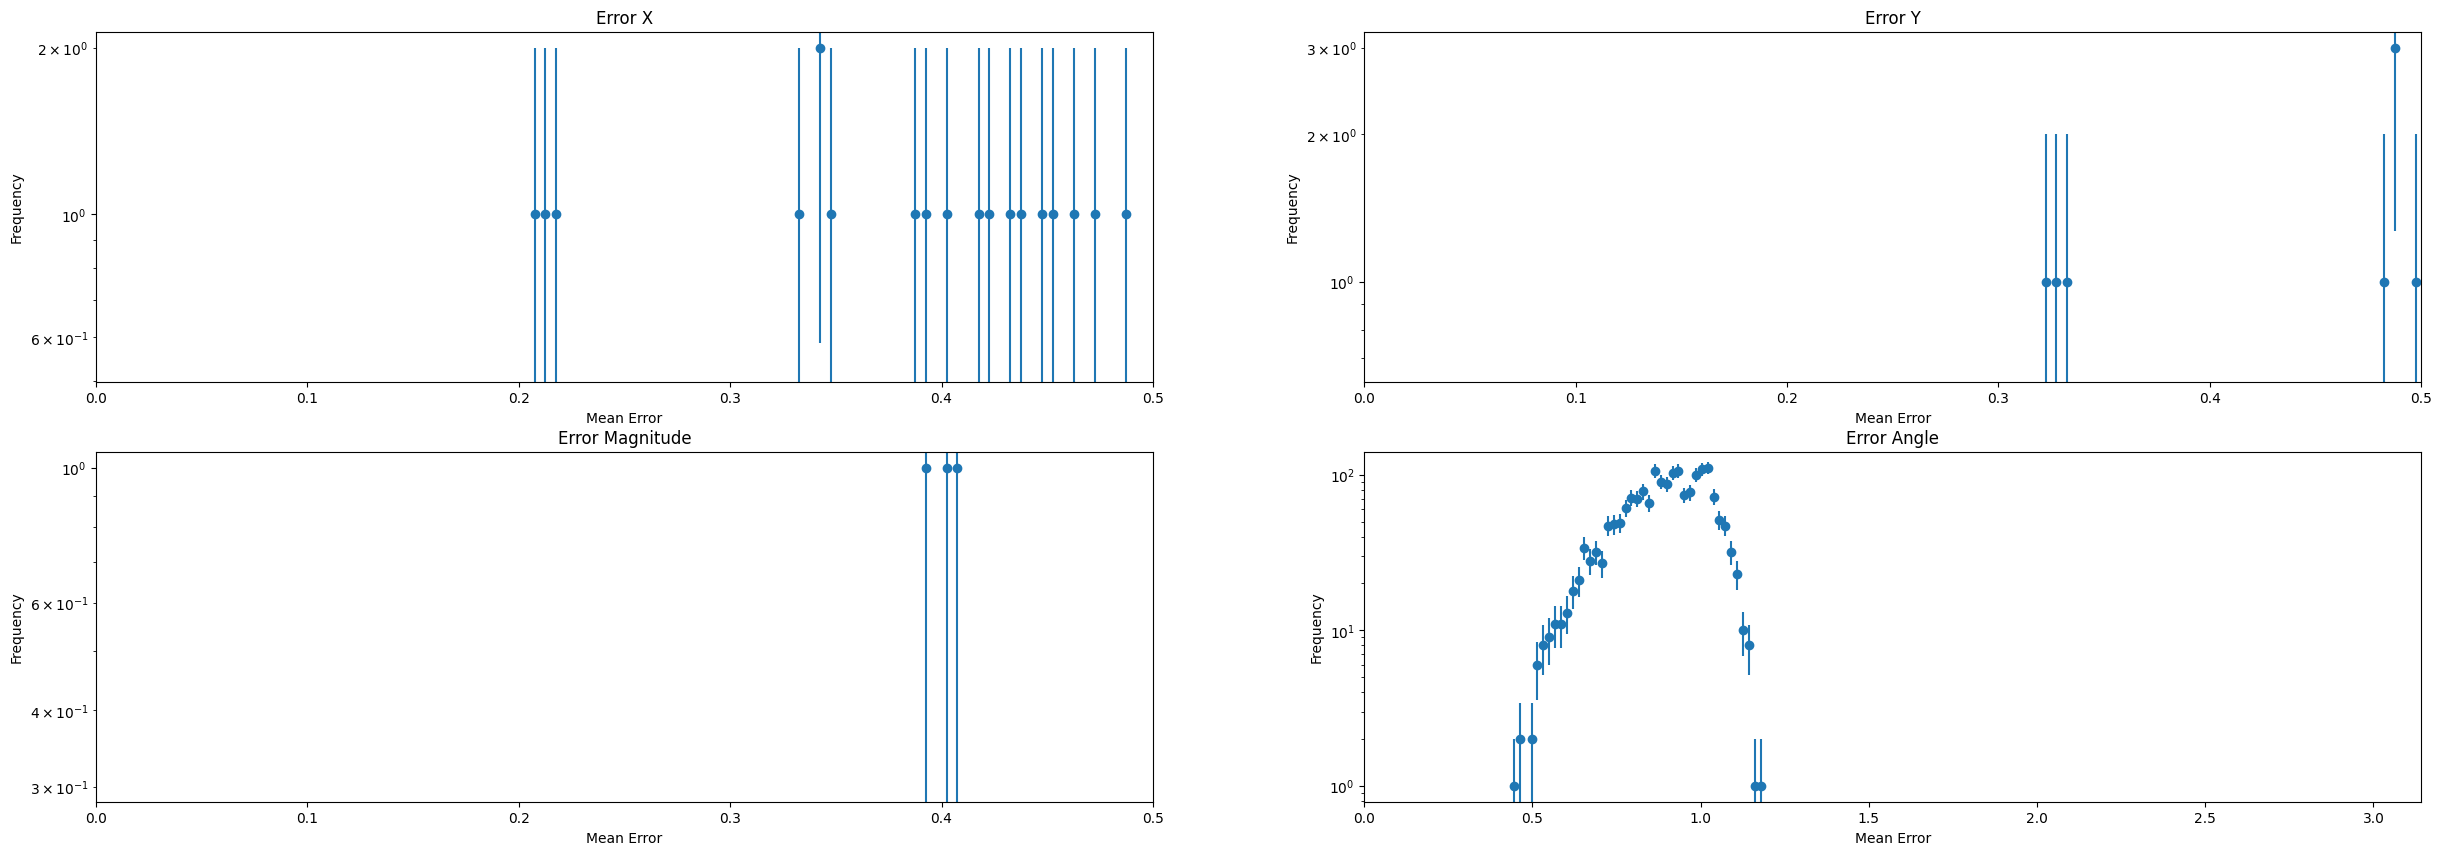

outer
Mean error x: 2.099520399570465
Mean error y: 2.1953653504593036
Mean error magnitude: 3.060611666767371
Mean error angle: 0.8852507207649095
Mean error x std: 0.46914292131225405
Mean error y std: 0.45502320083872133
Mean error magnitude std: 0.6540246782194338
Mean error angle std: 0.1330755260587568


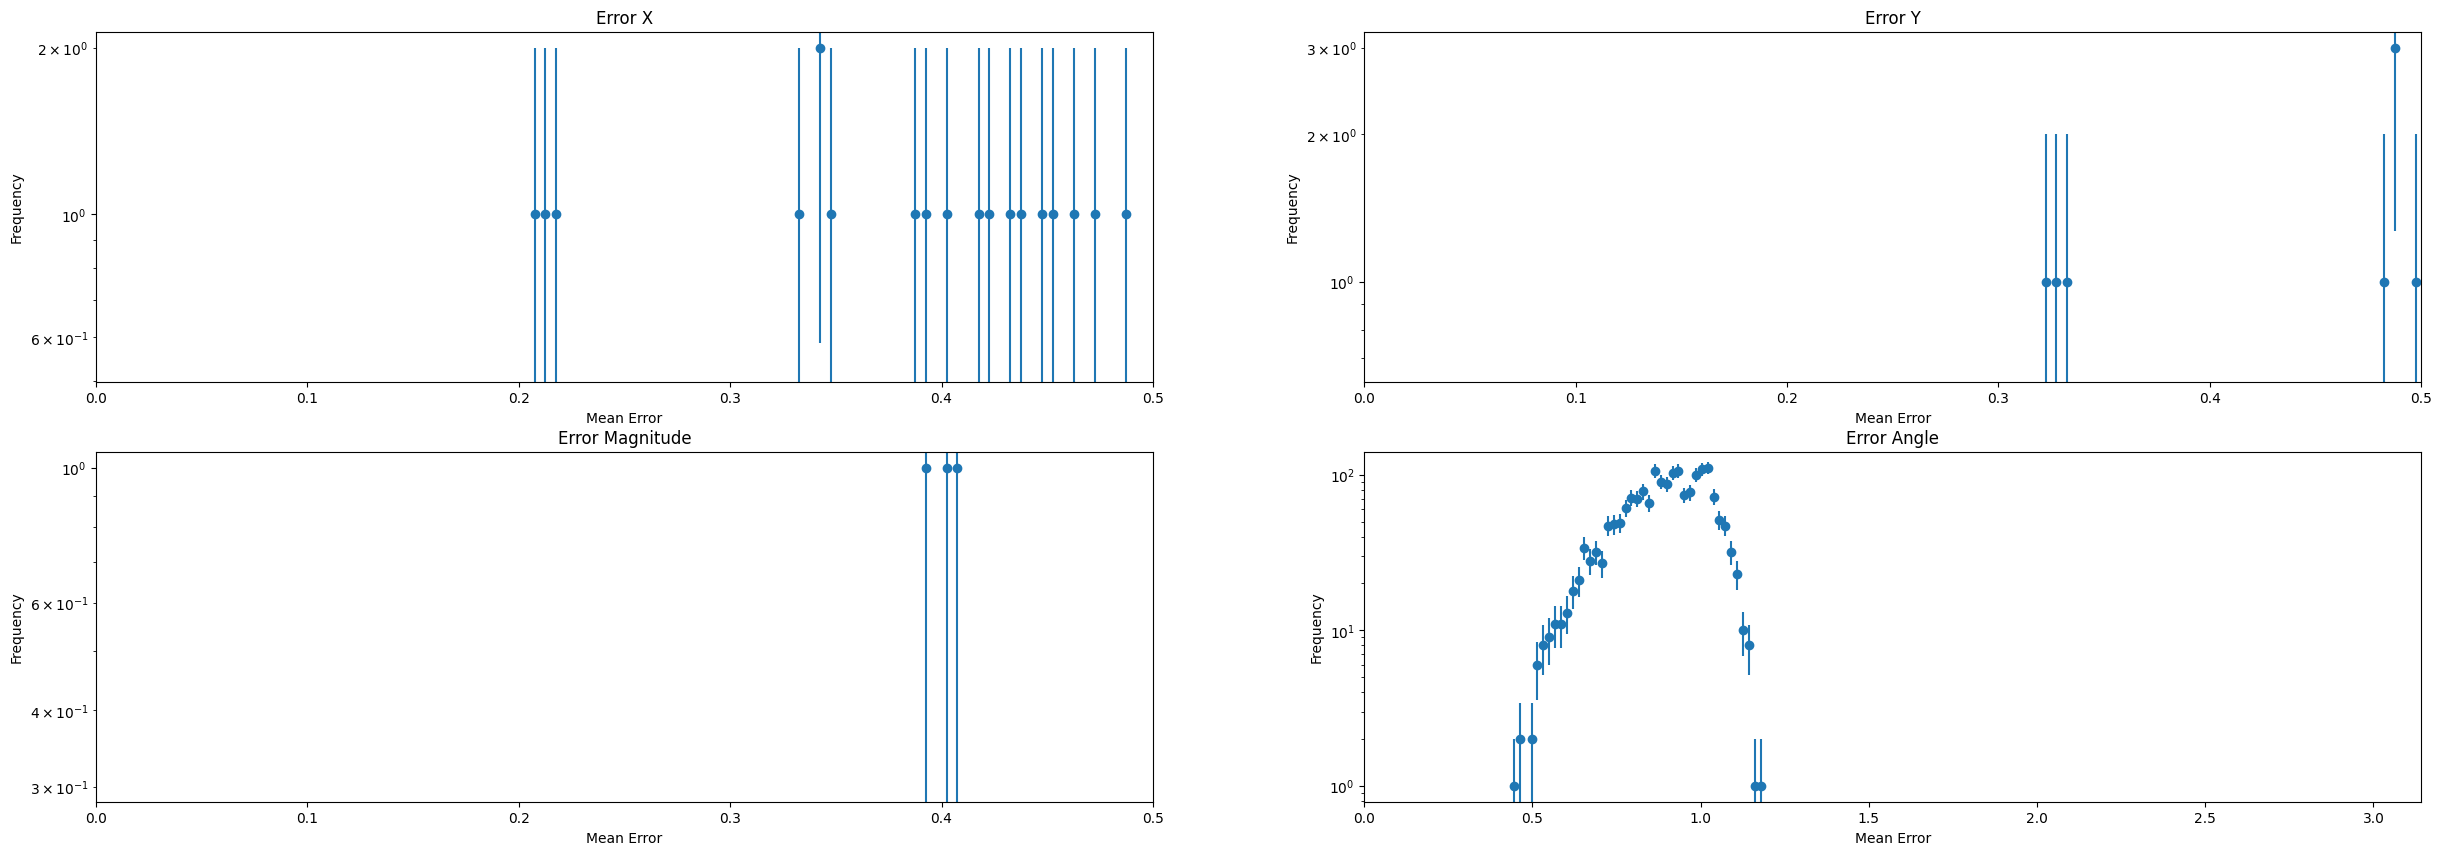

In [11]:
#plot the aperture errors
key = "aperture"
i = -1
if True:
# for i in range(len(error_dict["aperture"]["x"])):
    for key in error_dict.keys():
        error_x = error_dict[key]["x"][i]
        error_y = error_dict[key]["y"][i]
        error_mag = error_dict[key]["mag"][i]
        error_ang = error_dict[key]["ang"][i]
        print(key)
        print("Mean error x:", np.mean(error_x))
        print("Mean error y:", np.mean(error_y))
        print("Mean error magnitude:", np.mean(error_mag))
        print("Mean error angle:", np.mean(error_ang))
        print("Mean error x std:", np.std(error_x))
        print("Mean error y std:", np.std(error_y))
        print("Mean error magnitude std:", np.std(error_mag))
        print("Mean error angle std:", np.std(error_ang))
        plot_histograms(error_x, error_y, error_mag, error_ang)

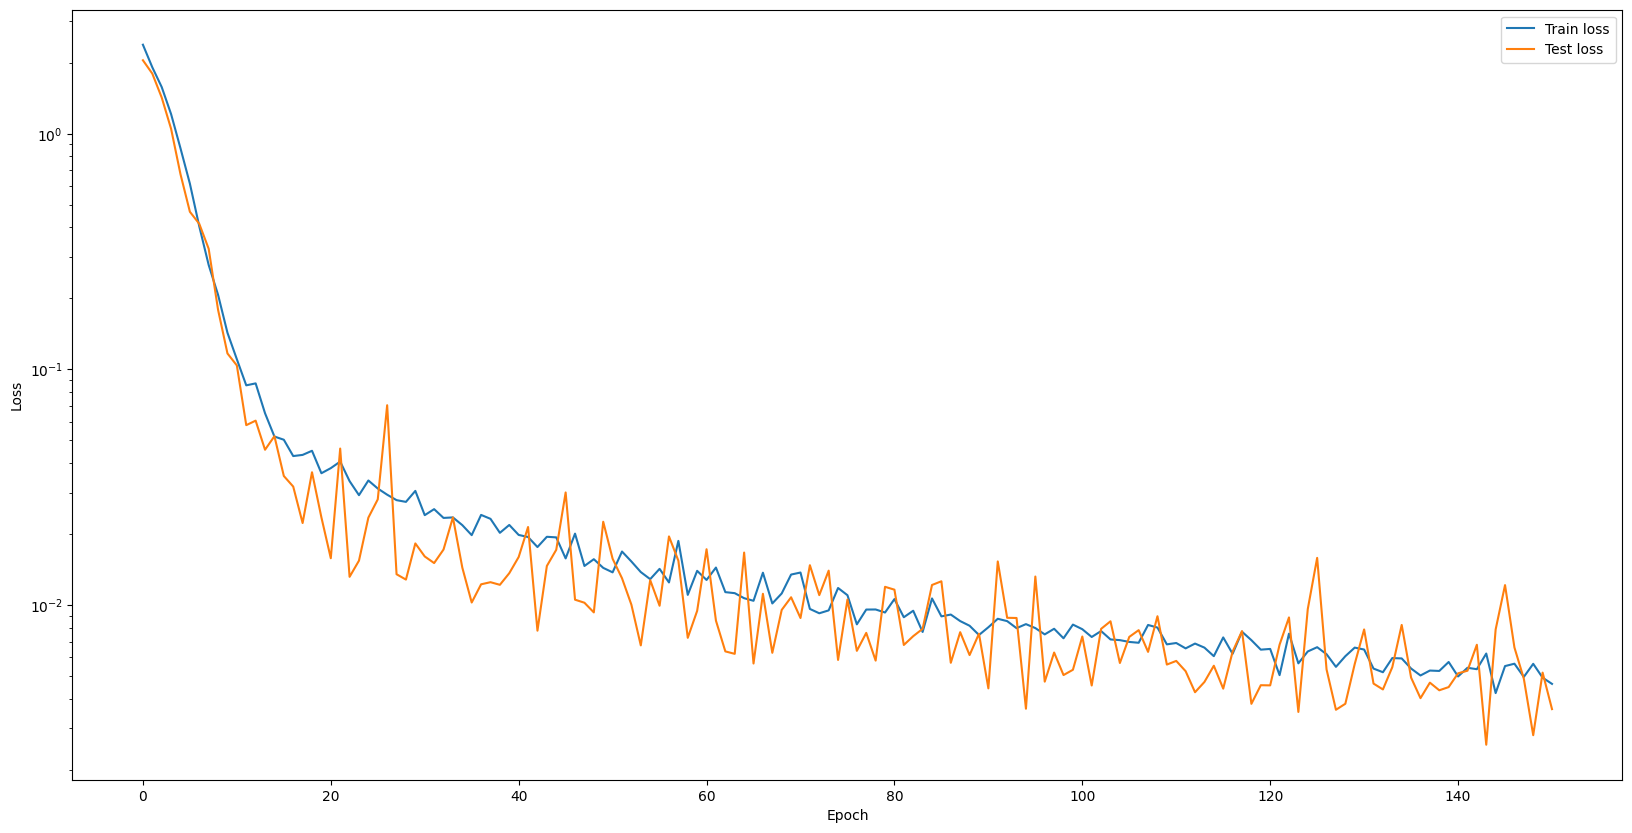

In [54]:
# load train_hist.pkl and test_hist.pkl and plot the loss
with open("../train_hist.pkl", "rb") as f:
    train_hist = pickle.load(f)
with open("../test_hist.pkl", "rb") as f:
    test_hist = pickle.load(f)

# train test split
split = (0.9, 0.1)

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(np.array(train_hist)/split[0], label="Train loss")
ax.plot(np.array(test_hist)/split[1], label="Test loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_yscale("log")
ax.legend()
plt.show()
